# Salinity budget on the shelf

"How does the freshwater budget, and its components, integrated over the shelf change? There will be changes due to the input salinity of the basal melt, changing salinity restoring, changing sea ice formation/melt, other air-sea FW fluxes (evap), and cross-slope transports of fresh/salty waters."

Diags:
`salt`

`sfc_salt_flux_restore`

`sfc_hflux_from_runoff`

`sfc_salt_flux_ice`

`sfc_hflux_pme` (?)

`frazil_3d_int_z` (?)

`pme_river`

## Check units of quantities!!

Also, write up salt budget?


In [1]:
%matplotlib inline

import cosima_cookbook as cc
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
import cartopy.crs as ccrs
import xarray as xr
import cmocean.cm as cmocean
import glob
import matplotlib.path as mpath
import matplotlib.colors as col

import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

from dask.distributed import Client


In [2]:
client = Client()
client


<Client: 'tcp://127.0.0.1:33187' processes=7 threads=28, memory=250.00 GiB>

In [3]:
master_session = cc.database.create_session()

control = '01deg_jra55v13_ryf9091'

#session_name = '/g/data/e14/pc5520/model_data/access-om2/basal_melt_MOM5/basal_melt_MOM5.db'
session_name ='/g/data/x77/cy8964/databases/basal_melt_MOM5_v2.db'
#session_name = '/g/data/v45/akm157/model_data/access-om2/basal_melt_MOM5/basal_melt_MOM5.db'
basal_melt_session = cc.database.create_session(session_name)

# temperature of meltwater using Gade line:
basal = 'accessom2-GPC015'
iceberg = 'accessom2-GPC018'


In [4]:
expt = basal
session = basal_melt_session

geolon_t = cc.querying.getvar(expt,'geolon_t',session, n=1)
geolat_t = cc.querying.getvar(expt,'geolat_t',session, n=1)


## Salinity Change
These are for ONE YEAR! 

In [15]:
# salinity change from restarts

# copy from heat budget notebook (Adele)

# heat content change:
# We need to calculate this from snapshots from the restarts.

salt_dummy = cc.querying.getvar(control, 'salt', master_session, n=1,frequency='1 monthly')

# note I had to collate these restarts first:
filepath = '/scratch/v45/akm157/access-om2/archive/'+control+'/restart995/ocean/ocean_temp_salt.res.nc'
restart1t = xr.open_dataset(filepath)
# only 1 time snapshot:
salt_init = restart1t.salt[0,...]
# fix coords:
salt_init.coords['zaxis_1'] = salt_dummy['st_ocean'].values
salt_init.coords['yaxis_1'] = salt_dummy['yt_ocean'].values
salt_init.coords['xaxis_1'] = salt_dummy['xt_ocean'].values
salt_init = salt_init.rename(({'zaxis_1':'st_ocean', 'yaxis_1':'yt_ocean', 'xaxis_1':'xt_ocean'}))
salt_init = salt_init.drop_vars('Time')

filepath = '/scratch/v45/akm157/access-om2/archive/'+control+'/restart995/ocean/ocean_thickness.res.nc'
restart1z = xr.open_dataset(filepath)
# only 1 time snapshot:
dzt_init = restart1z.rho_dzt[0,...]
# fix coords:
dzt_init.coords['zaxis_1'] = salt_dummy['st_ocean'].values
dzt_init.coords['yaxis_1'] = salt_dummy['yt_ocean'].values
dzt_init.coords['xaxis_1'] = salt_dummy['xt_ocean'].values
dzt_init = dzt_init.rename(({'zaxis_1':'st_ocean', 'yaxis_1':'yt_ocean', 'xaxis_1':'xt_ocean'}))
dzt_init = dzt_init.drop_vars('Time')

filepath = '/scratch/v45/akm157/access-om2/archive/'+control+'/restart1015/ocean/ocean_temp_salt.res.nc'
restart2t = xr.open_dataset(filepath)
# only 1 time snapshot:
salt_end = restart2t.salt[0,...]
# fix coords:
salt_end.coords['zaxis_1'] = salt_dummy['st_ocean'].values
salt_end.coords['yaxis_1'] = salt_dummy['yt_ocean'].values
salt_end.coords['xaxis_1'] = salt_dummy['xt_ocean'].values
salt_end = salt_end.rename(({'zaxis_1':'st_ocean', 'yaxis_1':'yt_ocean', 'xaxis_1':'xt_ocean'}))
salt_end = salt_end.drop_vars('Time')

filepath = '/scratch/v45/akm157/access-om2/archive/'+control+'/restart1015/ocean/ocean_thickness.res.nc'
restart2z = xr.open_dataset(filepath)
# only 1 time snapshot:
dzt_end = restart2z.rho_dzt[0,...]
# fix coords:
dzt_end.coords['zaxis_1'] = salt_dummy['st_ocean'].values
dzt_end.coords['yaxis_1'] = salt_dummy['yt_ocean'].values
dzt_end.coords['xaxis_1'] = salt_dummy['xt_ocean'].values
dzt_end = dzt_end.rename(({'zaxis_1':'st_ocean', 'yaxis_1':'yt_ocean', 'xaxis_1':'xt_ocean'}))
dzt_end = dzt_end.drop_vars('Time')


In [16]:
# compute salt content change:

# J / kg / degC
c_p = 3992.1
rho0 = 1035.0
area = cc.querying.getvar(control, 'area_t', master_session, n=1).load()

# there is a factor of rho_0 in dzt here:
salt_content_change = (1/rho0*((salt_end*dzt_end).sum('st_ocean') - (salt_init*dzt_init).sum('st_ocean'))*area).sum()

print('Net salt content change over this period =',salt_content_change.values/1e12,'x 10^12 g/kg m^3')

Net salt content change over this period = -0.49483679296248356 x 10^12 g/kg m^3


Now repeat for basal perturbation

In [17]:
# salinity change from restarts

# copy from heat budget notebook (Adele)

# heat content change:
# We need to calculate this from snapshots from the restarts.

salt_dummy = cc.querying.getvar(basal, 'salt', basal_melt_session, n=1,frequency='1 monthly')

# use same first restarts as control:
filepath = '/scratch/v45/akm157/access-om2/archive/'+control+'/restart995/ocean/ocean_temp_salt.res.nc'
restart1t = xr.open_dataset(filepath)
# only 1 time snapshot:
salt_init = restart1t.salt[0,...]
# fix coords:
salt_init.coords['zaxis_1'] = salt_dummy['st_ocean'].values
salt_init.coords['yaxis_1'] = salt_dummy['yt_ocean'].values
salt_init.coords['xaxis_1'] = salt_dummy['xt_ocean'].values
salt_init = salt_init.rename(({'zaxis_1':'st_ocean', 'yaxis_1':'yt_ocean', 'xaxis_1':'xt_ocean'}))
salt_init = salt_init.drop_vars('Time')

filepath = '/scratch/v45/akm157/access-om2/archive/'+control+'/restart995/ocean/ocean_thickness.res.nc'
restart1z = xr.open_dataset(filepath)
# only 1 time snapshot:
dzt_init = restart1z.rho_dzt[0,...]
# fix coords:
dzt_init.coords['zaxis_1'] = salt_dummy['st_ocean'].values
dzt_init.coords['yaxis_1'] = salt_dummy['yt_ocean'].values
dzt_init.coords['xaxis_1'] = salt_dummy['xt_ocean'].values
dzt_init = dzt_init.rename(({'zaxis_1':'st_ocean', 'yaxis_1':'yt_ocean', 'xaxis_1':'xt_ocean'}))
dzt_init = dzt_init.drop_vars('Time')

#basal restart
filepath = '/g/data/ik11/outputs/access-om2-01/basal_melt_outputs/'+basal+'/restarts/restart1002/ocean/ocean_temp_salt.res.nc'
restart2t = xr.open_dataset(filepath)
# only 1 time snapshot:
salt_end = restart2t.salt[0,...]
# fix coords:
salt_end.coords['zaxis_1'] = salt_dummy['st_ocean'].values
salt_end.coords['yaxis_1'] = salt_dummy['yt_ocean'].values
salt_end.coords['xaxis_1'] = salt_dummy['xt_ocean'].values
salt_end = salt_end.rename(({'zaxis_1':'st_ocean', 'yaxis_1':'yt_ocean', 'xaxis_1':'xt_ocean'}))
salt_end = salt_end.drop_vars('Time')

filepath = '/g/data/ik11/outputs/access-om2-01/basal_melt_outputs/'+basal+'/restarts/restart1002/ocean/ocean_thickness.res.nc'
restart2z = xr.open_dataset(filepath)
# only 1 time snapshot:
dzt_end = restart2z.rho_dzt[0,...]
# fix coords:
dzt_end.coords['zaxis_1'] = salt_dummy['st_ocean'].values
dzt_end.coords['yaxis_1'] = salt_dummy['yt_ocean'].values
dzt_end.coords['xaxis_1'] = salt_dummy['xt_ocean'].values
dzt_end = dzt_end.rename(({'zaxis_1':'st_ocean', 'yaxis_1':'yt_ocean', 'xaxis_1':'xt_ocean'}))
dzt_end = dzt_end.drop_vars('Time')



In [18]:
# compute salt content change:

# J / kg / degC
c_p = 3992.1
rho0 = 1035.0
area = cc.querying.getvar(control, 'area_t', master_session, n=1).load()

# there is a factor of rho_0 in dzt here:
salt_content_change = (1/rho0*((salt_end*dzt_end).sum('st_ocean') - (salt_init*dzt_init).sum('st_ocean'))*area).sum()

print('Net salt content change over this period =',salt_content_change.values/1e12,'x 10^12 g/kg m^3')

Net salt content change over this period = -52.31679257402289 x 10^12 g/kg m^3


These are over the whole ocean. Basal's is much bigger. Also this is for **ONE YEAR**, 2150-01-01 to 2151-01-01

## Masking shelf

Need to mask just the shelf (<1000m), but parts of shelf have depth > 1000m so can't just do a .where()


use from https://github.com/COSIMA/cosima-recipes/blob/master/DocumentedExamples/Surface_Water_Mass_Transformation.ipynb


In [5]:
def shelf_mask_isobath(var):
    '''
    Masks ACCESS-OM2-01 variables by the region polewards of the 1000m isobath as computed using 
    a script contributed by Adele Morrison.
    Only to be used with ACCESS-OM2-0.1 output!
    '''
    contour_file = np.load('/g/data/ik11/grids/Antarctic_slope_contour_1000m.npz')
    
    shelf_mask = contour_file['contour_masked_above']
    yt_ocean = contour_file['yt_ocean']
    xt_ocean = contour_file['xt_ocean']
    
    # in this file the points along the isobath are given a positive value, the points outside (northwards) 
    # of the isobath are given a value of -100 and all the points on the continental shelf have a value of 0 
    # so we mask for the 0 values 
    shelf_mask[np.where(shelf_mask!=0)] = np.nan
    shelf_mask = shelf_mask+1
    shelf_map = np.nan_to_num(shelf_mask)
    shelf_mask = xr.DataArray(shelf_mask, coords = [('yt_ocean', yt_ocean), ('xt_ocean', xt_ocean)])
    shelf_map = xr.DataArray(shelf_map, coords = [('yt_ocean', yt_ocean), ('xt_ocean', xt_ocean)])
    
    # then we want to multiply the variable with the mask so we need to account for the shape of the mask. 
    # The mask uses a northern cutoff of 59S.
    masked_var = var.sel(yt_ocean = slice(-90, -59.03)) * shelf_mask
    return masked_var, shelf_map


In [6]:
ht = cc.querying.getvar(expt,'ht', session, n=1) 
ht = ht.sel(yt_ocean = slice(-90, -59))
land_mask = (ht*0).fillna(1)
yt_ocean = ht.yt_ocean.values
xt_ocean = ht.xt_ocean.values
ht_shelf , shelf_mask = shelf_mask_isobath(ht)

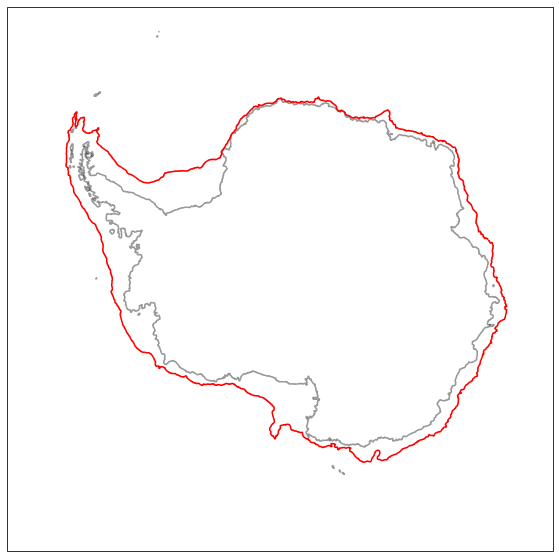

In [7]:
fig = plt.figure(num=1,figsize=(10, 10))
ax = plt.subplot(projection=ccrs.SouthPolarStereo())

ax.contour(xt_ocean, yt_ocean, land_mask,[0,1], colors = 'k', alpha = 0.4, transform=ccrs.PlateCarree())
ax.contour(xt_ocean, yt_ocean, shelf_mask.values, [0, 1], colors = 'r', transform=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, -59], ccrs.PlateCarree())


## Plot vertically integrated quantities

In [50]:
# set times to be last 5 years of 20 year perturbation

start_time = '2165-01-01'
end_time = '2169-12-31'

In [51]:
sfc_salt_flux_restore_basal = cc.querying.getvar(basal,'sfc_salt_flux_restore', basal_melt_session, 
                                                 start_time = start_time, end_time = end_time) 
sfc_salt_flux_restore_basal = sfc_salt_flux_restore_basal.sel(yt_ocean = slice(-90, -59)).sel(time = slice(start_time, end_time))
sfc_salt_flux_restore_basal = (sfc_salt_flux_restore_basal*sfc_salt_flux_restore_basal.time.dt.days_in_month).sum('time')/sfc_salt_flux_restore_basal.time.dt.days_in_month.sum('time')
sfc_salt_flux_restore_basal_shelf, shelf_mask = shelf_mask_isobath(sfc_salt_flux_restore_basal)

sfc_salt_flux_restore_control = cc.querying.getvar(control,'sfc_salt_flux_restore', master_session, 
                                                 start_time = start_time, end_time = end_time) 
sfc_salt_flux_restore_control = sfc_salt_flux_restore_control.sel(yt_ocean = slice(-90, -59)).sel(time = slice(start_time, end_time))
sfc_salt_flux_restore_control = (sfc_salt_flux_restore_control*sfc_salt_flux_restore_control.time.dt.days_in_month).sum('time')/sfc_salt_flux_restore_control.time.dt.days_in_month.sum('time')
sfc_salt_flux_restore_control_shelf, shelf_mask = shelf_mask_isobath(sfc_salt_flux_restore_control)

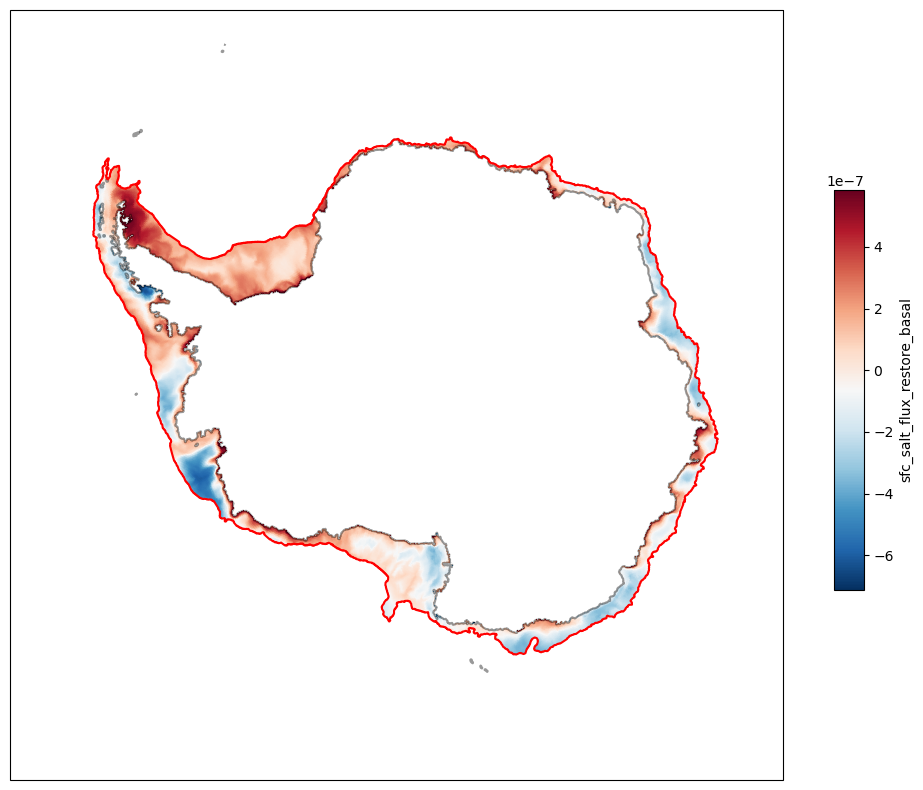

In [52]:

fig = plt.figure(num=1,figsize=(10, 10))
ax = plt.subplot(projection=ccrs.SouthPolarStereo())

ax.contour(xt_ocean, yt_ocean, land_mask,[0,1], colors = 'k', alpha = 0.4, transform=ccrs.PlateCarree())
ax.contour(xt_ocean, yt_ocean, shelf_mask.values, [0, 1], colors = 'r', transform=ccrs.PlateCarree())
p1 = ax.pcolormesh(xt_ocean, yt_ocean, sfc_salt_flux_restore_basal_shelf.where(land_mask ==0).values, transform=ccrs.PlateCarree(),
                  cmap = 'RdBu_r')
cax = fig.add_axes([0.95, 0.3, 0.03, 0.4])
plt.colorbar(p1, cax = cax, label = 'sfc_salt_flux_restore_basal')
ax.set_extent([-180, 180, -90, -59], ccrs.PlateCarree())


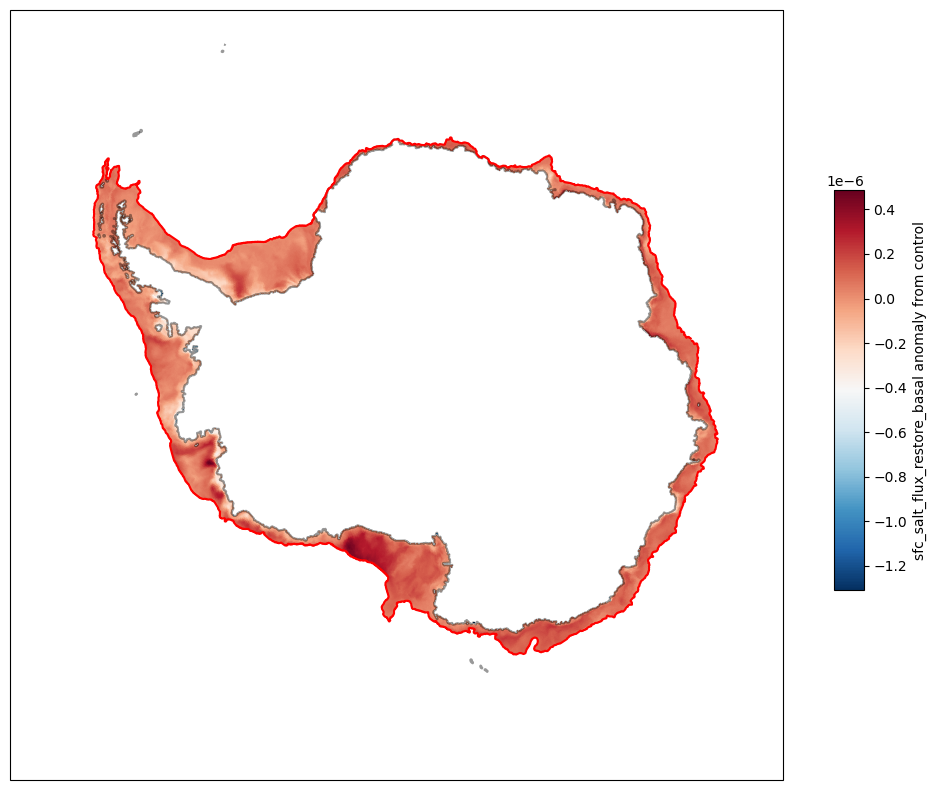

In [53]:
fig = plt.figure(num=1,figsize=(10, 10))
ax = plt.subplot(projection=ccrs.SouthPolarStereo())

ax.contour(xt_ocean, yt_ocean, land_mask,[0,1], colors = 'k', alpha = 0.4, transform=ccrs.PlateCarree())
ax.contour(xt_ocean, yt_ocean, shelf_mask.values, [0, 1], colors = 'r', transform=ccrs.PlateCarree())
p1 = ax.pcolormesh(xt_ocean, yt_ocean, (sfc_salt_flux_restore_basal_shelf-sfc_salt_flux_restore_control_shelf).where(land_mask ==0).values, transform=ccrs.PlateCarree(),
                  cmap = 'RdBu_r')
cax = fig.add_axes([0.95, 0.3, 0.03, 0.4])
plt.colorbar(p1, cax = cax, label = 'sfc_salt_flux_restore_basal anomaly from control')
ax.set_extent([-180, 180, -90, -59], ccrs.PlateCarree())


In [67]:
area = cc.querying.getvar(control, 'area_t', master_session, n=1).load()

print('control sfc_salt_flux_restore = '+str((sfc_salt_flux_restore_control_shelf*area).sum().values))

print('basal   sfc_salt_flux_restore = '+str((sfc_salt_flux_restore_basal_shelf*area).sum().values))


control sfc_salt_flux_restore = -64929.89863982692
basal   sfc_salt_flux_restore = 71268.39359567211


In [54]:
sfc_salt_flux_ice_basal = cc.querying.getvar(basal,'sfc_salt_flux_ice', basal_melt_session, 
                                                 start_time = start_time, end_time = end_time) 
sfc_salt_flux_ice_basal = sfc_salt_flux_ice_basal.sel(yt_ocean = slice(-90, -59)).sel(time = slice(start_time, end_time))
sfc_salt_flux_ice_basal = (sfc_salt_flux_ice_basal*sfc_salt_flux_ice_basal.time.dt.days_in_month).sum('time')/sfc_salt_flux_ice_basal.time.dt.days_in_month.sum('time')
sfc_salt_flux_ice_basal_shelf, shelf_mask = shelf_mask_isobath(sfc_salt_flux_ice_basal)

sfc_salt_flux_ice_control = cc.querying.getvar(control,'sfc_salt_flux_ice', master_session, 
                                                 start_time = start_time, end_time = end_time) 
sfc_salt_flux_ice_control = sfc_salt_flux_ice_control.sel(yt_ocean = slice(-90, -59)).sel(time = slice(start_time, end_time))
sfc_salt_flux_ice_control = (sfc_salt_flux_ice_control*sfc_salt_flux_ice_control.time.dt.days_in_month).sum('time')/sfc_salt_flux_ice_control.time.dt.days_in_month.sum('time')
sfc_salt_flux_ice_control_shelf, shelf_mask = shelf_mask_isobath(sfc_salt_flux_ice_control)



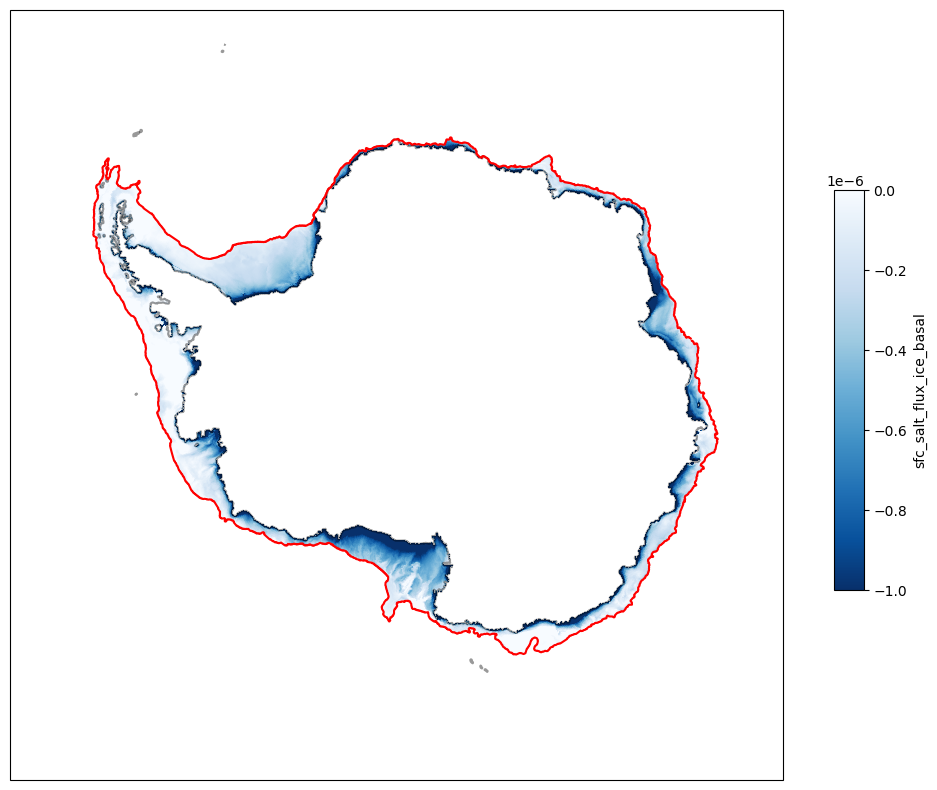

In [55]:
fig = plt.figure(num=1,figsize=(10, 10))
ax = plt.subplot(projection=ccrs.SouthPolarStereo())

ax.contour(xt_ocean, yt_ocean, land_mask,[0,1], colors = 'k', alpha = 0.4, transform=ccrs.PlateCarree())
ax.contour(xt_ocean, yt_ocean, shelf_mask.values, [0, 1], colors = 'r', transform=ccrs.PlateCarree())
p1 = ax.pcolormesh(xt_ocean, yt_ocean, sfc_salt_flux_ice_basal_shelf.where(land_mask ==0).values, transform=ccrs.PlateCarree(),
                  cmap = 'Blues_r', vmax = 0, vmin = -1e-6)
cax = fig.add_axes([0.95, 0.3, 0.03, 0.4])
plt.colorbar(p1, cax = cax, label = 'sfc_salt_flux_ice_basal')
ax.set_extent([-180, 180, -90, -59], ccrs.PlateCarree())


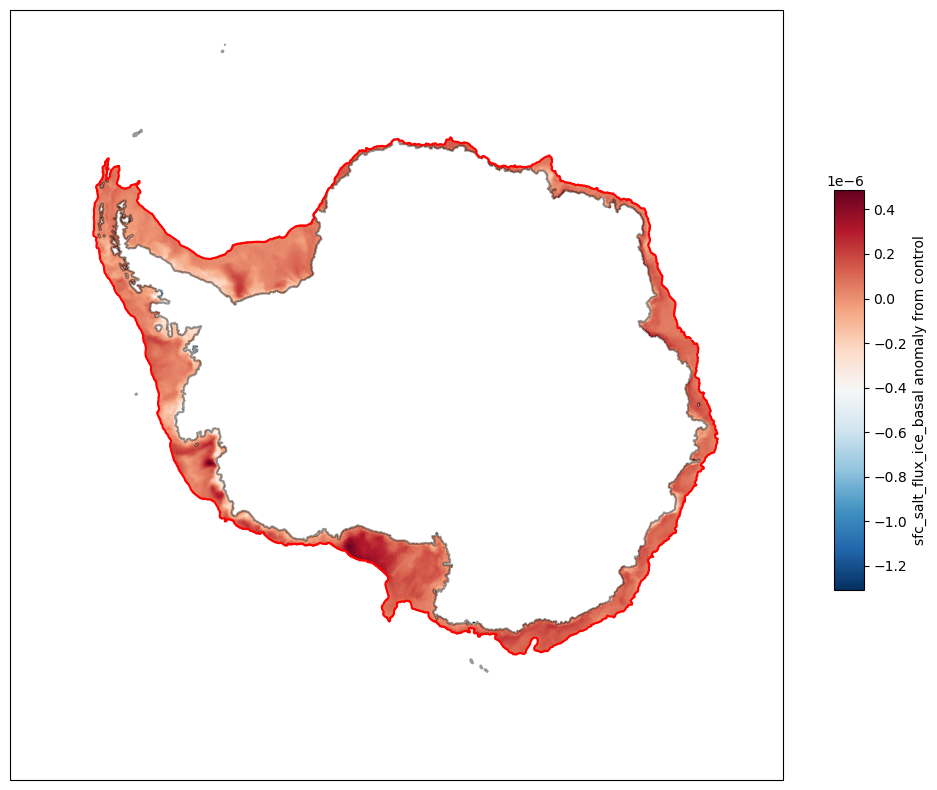

In [56]:
fig = plt.figure(num=1,figsize=(10, 10))
ax = plt.subplot(projection=ccrs.SouthPolarStereo())

ax.contour(xt_ocean, yt_ocean, land_mask,[0,1], colors = 'k', alpha = 0.4, transform=ccrs.PlateCarree())
ax.contour(xt_ocean, yt_ocean, shelf_mask.values, [0, 1], colors = 'r', transform=ccrs.PlateCarree())
p1 = ax.pcolormesh(xt_ocean, yt_ocean, (sfc_salt_flux_restore_basal_shelf-sfc_salt_flux_restore_control_shelf).where(land_mask ==0).values, transform=ccrs.PlateCarree(),
                  cmap = 'RdBu_r')
cax = fig.add_axes([0.95, 0.3, 0.03, 0.4])
plt.colorbar(p1, cax = cax, label = 'sfc_salt_flux_ice_basal anomaly from control')
ax.set_extent([-180, 180, -90, -59], ccrs.PlateCarree())


In [68]:
print('control sfc_salt_flux_ice = '+str((sfc_salt_flux_ice_control_shelf*area).sum().values))

print('basal   sfc_salt_flux_ice = '+str((sfc_salt_flux_ice_basal_shelf*area).sum().values))


control sfc_salt_flux_ice = -1116929.482167469
basal   sfc_salt_flux_ice = -1365413.3811735103


In [57]:

sfc_hflux_from_runoff_basal = cc.querying.getvar(basal,'sfc_hflux_from_runoff', basal_melt_session, 
                                                 start_time = start_time, end_time = end_time, ncfile = 'ocean_month.nc') 
sfc_hflux_from_runoff_basal = sfc_hflux_from_runoff_basal.sel(yt_ocean = slice(-90, -59)).sel(time = slice(start_time, end_time))
sfc_hflux_from_runoff_basal = (sfc_hflux_from_runoff_basal*sfc_hflux_from_runoff_basal.time.dt.days_in_month).sum('time')/sfc_hflux_from_runoff_basal.time.dt.days_in_month.sum('time')
sfc_hflux_from_runoff_basal_shelf, shelf_mask = shelf_mask_isobath(sfc_hflux_from_runoff_basal)

sfc_hflux_from_runoff_control = cc.querying.getvar(control,'sfc_hflux_from_runoff', master_session, 
                                                 start_time = start_time, end_time = end_time , ncfile = 'ocean_month.nc') 
sfc_hflux_from_runoff_control = sfc_hflux_from_runoff_control.sel(yt_ocean = slice(-90, -59)).sel(time = slice(start_time, end_time))
sfc_hflux_from_runoff_control = (sfc_hflux_from_runoff_control*sfc_hflux_from_runoff_control.time.dt.days_in_month).sum('time')/sfc_hflux_from_runoff_control.time.dt.days_in_month.sum('time')
sfc_hflux_from_runoff_control_shelf, shelf_mask = shelf_mask_isobath(sfc_hflux_from_runoff_control)



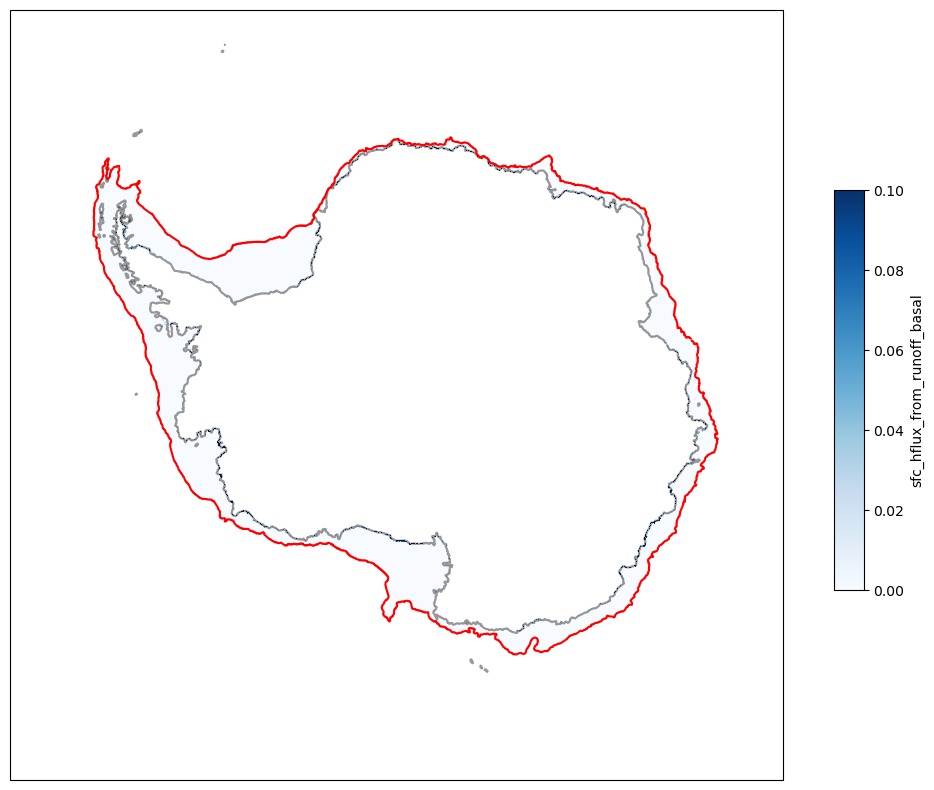

In [58]:
fig = plt.figure(num=1,figsize=(10, 10))
ax = plt.subplot(projection=ccrs.SouthPolarStereo())

ax.contour(xt_ocean, yt_ocean, land_mask,[0,1], colors = 'k', alpha = 0.4, transform=ccrs.PlateCarree())
ax.contour(xt_ocean, yt_ocean, shelf_mask.values, [0, 1], colors = 'r', transform=ccrs.PlateCarree())
p1 = ax.pcolormesh(xt_ocean, yt_ocean, sfc_hflux_from_runoff_basal_shelf.where(land_mask ==0).values, transform=ccrs.PlateCarree(),
                  cmap = 'Blues', vmin = 0, vmax = 0.1)
cax = fig.add_axes([0.95, 0.3, 0.03, 0.4])
plt.colorbar(p1, cax = cax, label = 'sfc_hflux_from_runoff_basal')
ax.set_extent([-180, 180, -90, -59], ccrs.PlateCarree())


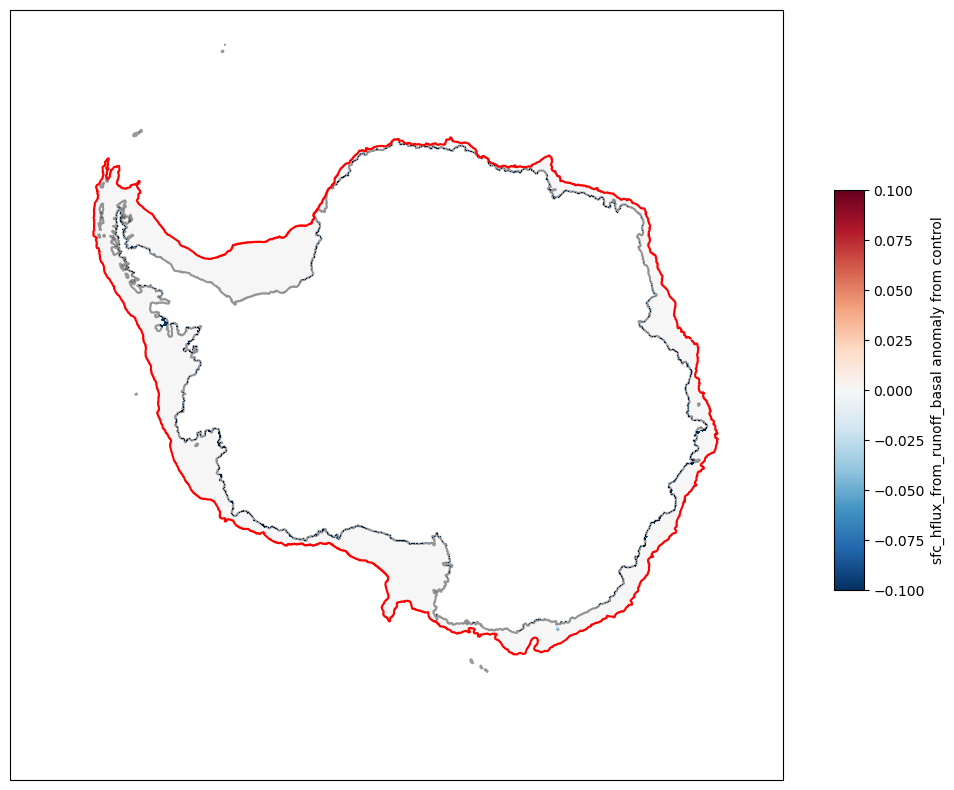

In [59]:
fig = plt.figure(num=1,figsize=(10, 10))
ax = plt.subplot(projection=ccrs.SouthPolarStereo())

ax.contour(xt_ocean, yt_ocean, land_mask,[0,1], colors = 'k', alpha = 0.4, transform=ccrs.PlateCarree())
ax.contour(xt_ocean, yt_ocean, shelf_mask.values, [0, 1], colors = 'r', transform=ccrs.PlateCarree())
p1 = ax.pcolormesh(xt_ocean, yt_ocean, (sfc_hflux_from_runoff_basal_shelf-sfc_hflux_from_runoff_control_shelf).where(land_mask ==0).values, transform=ccrs.PlateCarree(),
                  cmap = 'RdBu_r', vmin = -0.1, vmax = 0.1)
cax = fig.add_axes([0.95, 0.3, 0.03, 0.4])
plt.colorbar(p1, cax = cax, label = 'sfc_hflux_from_runoff_basal anomaly from control')
ax.set_extent([-180, 180, -90, -59], ccrs.PlateCarree())


In [60]:
area = cc.querying.getvar(control, 'area_t', master_session, n=1).load()

print('control sfc_hflux_from_runoff = '+str((sfc_hflux_from_runoff_control_shelf*area).sum().values))

print('basal   sfc_hflux_from_runoff = '+str((sfc_hflux_from_runoff_basal_shelf*area).sum().values))


control sfc_hflux_from_runoff = 55120206551.080574
basal   sfc_hflux_from_runoff = 10190166788.806711


In [61]:

sfc_hflux_pme_basal = cc.querying.getvar(basal,'sfc_hflux_pme', basal_melt_session, 
                                                 start_time = start_time, end_time = end_time, ncfile = 'ocean_month.nc') 
sfc_hflux_pme_basal = sfc_hflux_pme_basal.sel(yt_ocean = slice(-90, -59)).sel(time = slice(start_time, end_time))
sfc_hflux_pme_basal = (sfc_hflux_pme_basal*sfc_hflux_pme_basal.time.dt.days_in_month).sum('time')/sfc_hflux_pme_basal.time.dt.days_in_month.sum('time')
sfc_hflux_pme_basal_shelf, shelf_mask = shelf_mask_isobath(sfc_hflux_pme_basal)

sfc_hflux_pme_control = cc.querying.getvar(control,'sfc_hflux_pme', master_session, 
                                                 start_time = start_time, end_time = end_time , ncfile = 'ocean_month.nc') 
sfc_hflux_pme_control = sfc_hflux_pme_control.sel(yt_ocean = slice(-90, -59)).sel(time = slice(start_time, end_time))
sfc_hflux_pme_control = (sfc_hflux_pme_control*sfc_hflux_pme_control.time.dt.days_in_month).sum('time')/sfc_hflux_pme_control.time.dt.days_in_month.sum('time')
sfc_hflux_pme_control_shelf, shelf_mask = shelf_mask_isobath(sfc_hflux_pme_control)



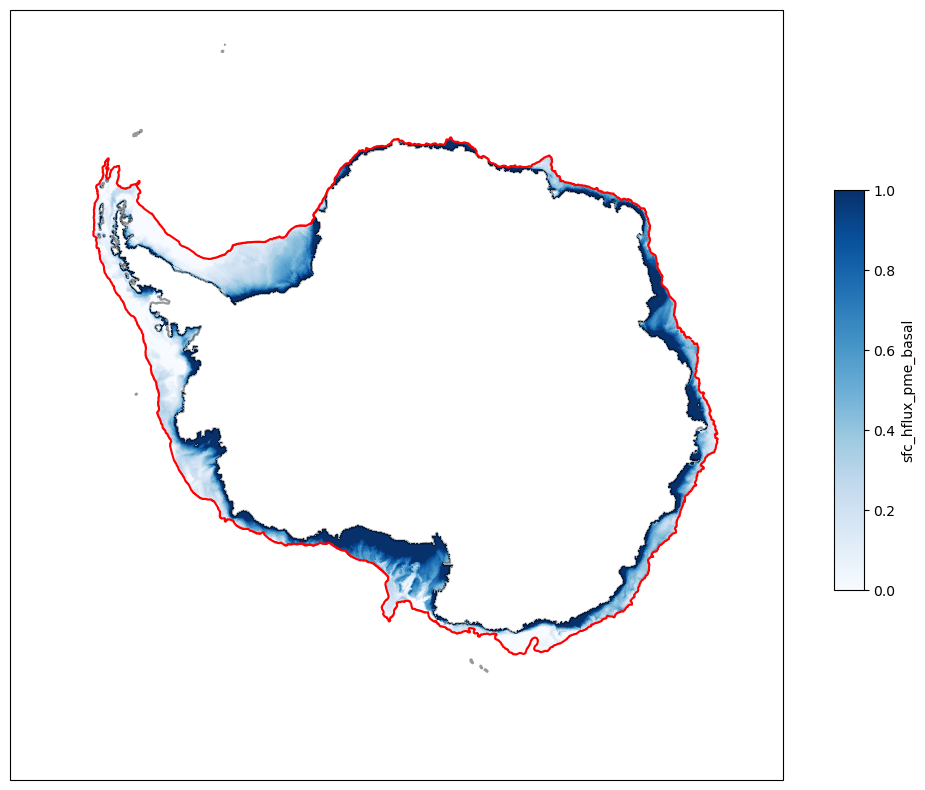

In [62]:
fig = plt.figure(num=1,figsize=(10, 10))
ax = plt.subplot(projection=ccrs.SouthPolarStereo())

ax.contour(xt_ocean, yt_ocean, land_mask,[0,1], colors = 'k', alpha = 0.4, transform=ccrs.PlateCarree())
ax.contour(xt_ocean, yt_ocean, shelf_mask.values, [0, 1], colors = 'r', transform=ccrs.PlateCarree())
p1 = ax.pcolormesh(xt_ocean, yt_ocean, sfc_hflux_pme_basal_shelf.where(land_mask ==0).values, transform=ccrs.PlateCarree(),
                  cmap = 'Blues', vmin = 0, vmax = 1)
cax = fig.add_axes([0.95, 0.3, 0.03, 0.4])
plt.colorbar(p1, cax = cax, label = 'sfc_hflux_pme_basal')
ax.set_extent([-180, 180, -90, -59], ccrs.PlateCarree())


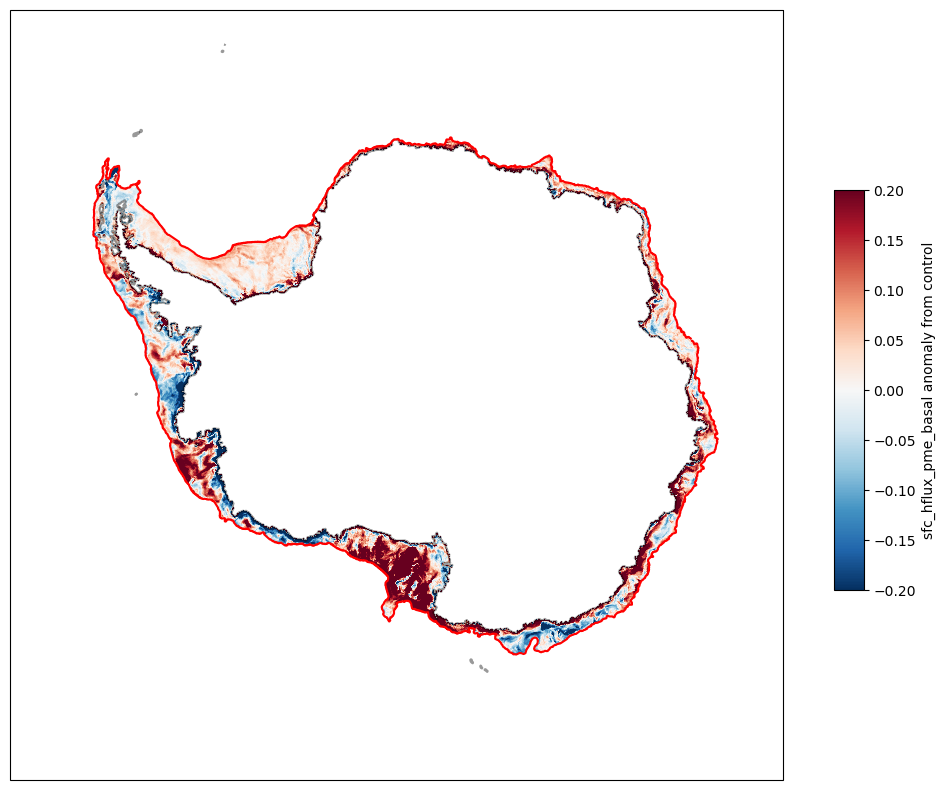

In [63]:
fig = plt.figure(num=1,figsize=(10, 10))
ax = plt.subplot(projection=ccrs.SouthPolarStereo())

ax.contour(xt_ocean, yt_ocean, land_mask,[0,1], colors = 'k', alpha = 0.4, transform=ccrs.PlateCarree())
ax.contour(xt_ocean, yt_ocean, shelf_mask.values, [0, 1], colors = 'r', transform=ccrs.PlateCarree())
p1 = ax.pcolormesh(xt_ocean, yt_ocean, (sfc_hflux_pme_basal_shelf-sfc_hflux_pme_control_shelf).where(land_mask ==0).values, transform=ccrs.PlateCarree(),
                  cmap = 'RdBu_r', vmin = -0.2, vmax = 0.2)
cax = fig.add_axes([0.95, 0.3, 0.03, 0.4])
plt.colorbar(p1, cax = cax, label = 'sfc_hflux_pme_basal anomaly from control')
ax.set_extent([-180, 180, -90, -59], ccrs.PlateCarree())


In [69]:
print('control sfc_hflux_pme = '+str((sfc_hflux_pme_control_shelf*area).sum().values))

print('basal   sfc_hflux_pme = '+str((sfc_hflux_pme_basal_shelf*area).sum().values))


control sfc_hflux_pme = 1790201102689.516
basal   sfc_hflux_pme = 2278867054363.507


In [64]:
frazil_3d_int_z_basal = cc.querying.getvar(basal,'frazil_3d_int_z', basal_melt_session, 
                                                 start_time = start_time, end_time = end_time, ncfile = 'ocean_month.nc') 
frazil_3d_int_z_basal = frazil_3d_int_z_basal.sel(yt_ocean = slice(-90, -59)).sel(time = slice(start_time, end_time))
frazil_3d_int_z_basal = (frazil_3d_int_z_basal*frazil_3d_int_z_basal.time.dt.days_in_month).sum('time')/frazil_3d_int_z_basal.time.dt.days_in_month.sum('time')
frazil_3d_int_z_basal_shelf, shelf_mask = shelf_mask_isobath(frazil_3d_int_z_basal)

frazil_3d_int_z_control = cc.querying.getvar(control,'frazil_3d_int_z', master_session, 
                                                 start_time = start_time, end_time = end_time , ncfile = 'ocean_month.nc') 
frazil_3d_int_z_control = frazil_3d_int_z_control.sel(yt_ocean = slice(-90, -59)).sel(time = slice(start_time, end_time))
frazil_3d_int_z_control = (frazil_3d_int_z_control*frazil_3d_int_z_control.time.dt.days_in_month).sum('time')/frazil_3d_int_z_control.time.dt.days_in_month.sum('time')
frazil_3d_int_z_control_shelf, shelf_mask = shelf_mask_isobath(frazil_3d_int_z_control)



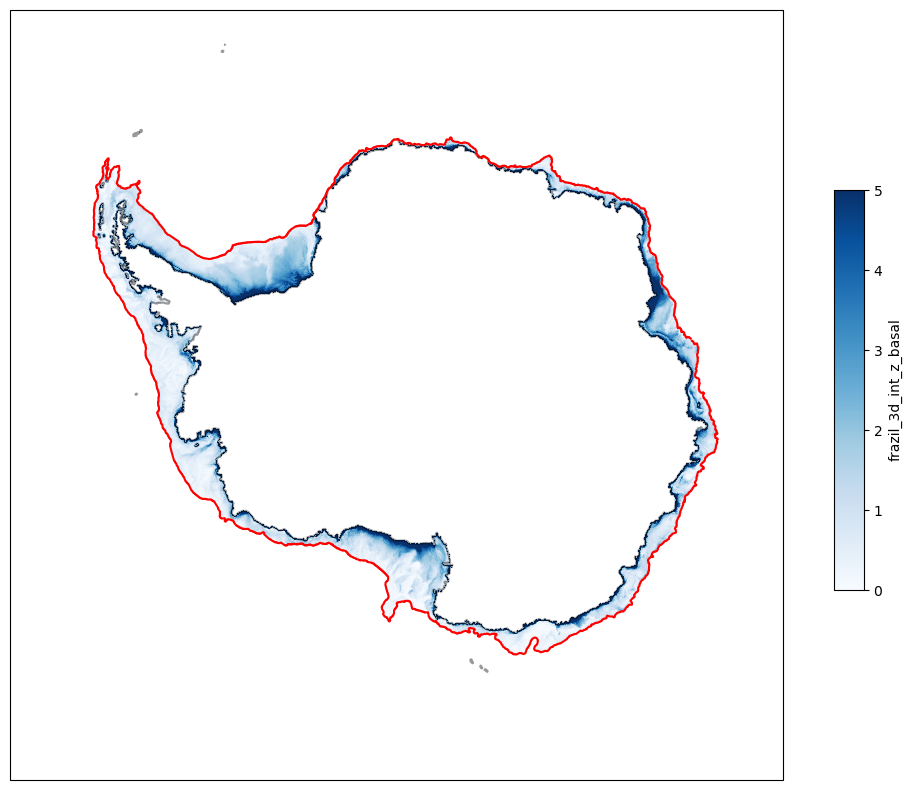

In [65]:
fig = plt.figure(num=1,figsize=(10, 10))
ax = plt.subplot(projection=ccrs.SouthPolarStereo())

ax.contour(xt_ocean, yt_ocean, land_mask,[0,1], colors = 'k', alpha = 0.4, transform=ccrs.PlateCarree())
ax.contour(xt_ocean, yt_ocean, shelf_mask.values, [0, 1], colors = 'r', transform=ccrs.PlateCarree())
p1 = ax.pcolormesh(xt_ocean, yt_ocean, frazil_3d_int_z_basal_shelf.where(land_mask ==0).values, transform=ccrs.PlateCarree(),
                  cmap = 'Blues', vmin = 0, vmax = 5)
cax = fig.add_axes([0.95, 0.3, 0.03, 0.4])
plt.colorbar(p1, cax = cax, label = 'frazil_3d_int_z_basal')
ax.set_extent([-180, 180, -90, -59], ccrs.PlateCarree())


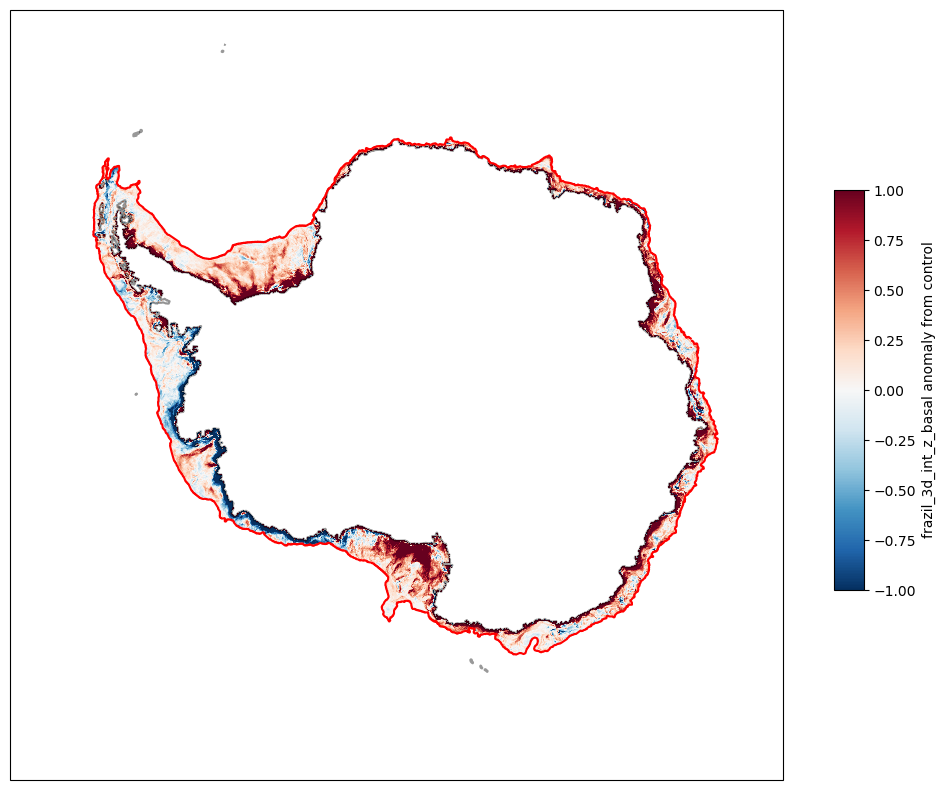

In [66]:
fig = plt.figure(num=1,figsize=(10, 10))
ax = plt.subplot(projection=ccrs.SouthPolarStereo())

ax.contour(xt_ocean, yt_ocean, land_mask,[0,1], colors = 'k', alpha = 0.4, transform=ccrs.PlateCarree())
ax.contour(xt_ocean, yt_ocean, shelf_mask.values, [0, 1], colors = 'r', transform=ccrs.PlateCarree())
p1 = ax.pcolormesh(xt_ocean, yt_ocean, (frazil_3d_int_z_basal_shelf-frazil_3d_int_z_control_shelf).where(land_mask ==0).values, transform=ccrs.PlateCarree(),
                  cmap = 'RdBu_r', vmin = -1, vmax = 1)
cax = fig.add_axes([0.95, 0.3, 0.03, 0.4])
plt.colorbar(p1, cax = cax, label = 'frazil_3d_int_z_basal anomaly from control')
ax.set_extent([-180, 180, -90, -59], ccrs.PlateCarree())


In [70]:
print('control frazil_3d_int_z = '+str((frazil_3d_int_z_control_shelf*area).sum().values))

print('basal   frazil_3d_int_z = '+str((frazil_3d_int_z_basal_shelf*area).sum().values))


control frazil_3d_int_z = 6579958192696.928
basal   frazil_3d_int_z = 12331380168278.826


## Plot maps 

In [11]:
area = cc.querying.getvar(control, 'area_t', master_session, n=1).load()
start_time = '2155-01-01'
end_time = '2159-12-31'

In [80]:
def plot(ax, var, expt, start_time, end_time, scale):
    if expt == control:
        session = master_session
    else:
        session = basal_melt_session
    if var == 'salt change':
        variable1 = cc.querying.getvar(expt,'salt', session, 
                                                     start_time = start_time, end_time = end_time, ncfile = 'ocean.nc') 
        units = variable1.units
        variable1 = variable1.sel(yt_ocean = slice(-90, -59)).sel(time = slice(start_time, end_time))
        dzt = cc.querying.getvar(expt,'dzt', session, 
                                                     start_time = start_time, end_time = end_time) 
        dzt = dzt.sel(yt_ocean = slice(-90, -59)).sel(time = slice(start_time, end_time))
        
        variable = (variable1.isel(time = -1)*dzt.isel(time = -1)-variable1.isel(time = 0)*dzt.isel(time = 0)).sum('st_ocean')/((dzt.isel(time = -1)+dzt.isel(time = 0))/2).sum('st_ocean')
    else:
        variable = cc.querying.getvar(expt,var, session, 
                                                     start_time = start_time, end_time = end_time) 
        units = variable.units
        variable = variable.sel(yt_ocean = slice(-90, -59)).sel(time = slice(start_time, end_time))
        variable = (variable*variable.time.dt.days_in_month).sum('time')/variable.time.dt.days_in_month.sum('time')
    variable_shelf, shelf_mask = shelf_mask_isobath(variable)
    ax.contour(xt_ocean, yt_ocean, land_mask,[0,1], colors = 'k', alpha = 0.4, transform=ccrs.PlateCarree())
    ax.contour(xt_ocean, yt_ocean, shelf_mask.values, [0, 1], colors = 'r', transform=ccrs.PlateCarree())
    p1 = ax.pcolormesh(xt_ocean, yt_ocean, (variable).where(land_mask ==0).values, transform=ccrs.PlateCarree(),
                      cmap = 'RdBu_r', vmin = -scale, vmax = scale)
    if var == 'salt change':
        plt.colorbar(p1, ax = ax, label = 'salt change ['+str(units)+'] for '+expt)
    else:
        plt.colorbar(p1, ax = ax, label = var+' , ['+str(units)+']')
    ax.set_title(expt)
    ax.set_extent([-180, 180, -90, -59], ccrs.PlateCarree())

def plot_anom(ax, var, expt1, expt2, start_time1, end_time1, start_time2, end_time2,scale):
    if expt1 == control:
        session1 = master_session
    else:
        session1 = basal_melt_session
    if expt2 == control:
        session2 = master_session
    else:
        session2 = basal_melt_session    
    variable1 = cc.querying.getvar(expt1,var, session1, 
                                                 start_time = start_time1, end_time = end_time1) 
    units = variable1.units
    variable1 = variable1.sel(yt_ocean = slice(-90, -59)).sel(time = slice(start_time1, end_time1))
    variable2 = cc.querying.getvar(expt2,var, session2, 
                                                 start_time = start_time2, end_time = end_time2) 
    variable2 = variable2.sel(yt_ocean = slice(-90, -59)).sel(time = slice(start_time2, end_time2))
    variable = (variable1*variable1.time.dt.days_in_month).sum('time')/variable1.time.dt.days_in_month.sum('time')-(variable2*variable2.time.dt.days_in_month).sum('time')/variable2.time.dt.days_in_month.sum('time')
    variable_shelf, shelf_mask = shelf_mask_isobath(variable)
    ax.contour(xt_ocean, yt_ocean, land_mask,[0,1], colors = 'k', alpha = 0.4, transform=ccrs.PlateCarree())
    ax.contour(xt_ocean, yt_ocean, shelf_mask.values, [0, 1], colors = 'r', transform=ccrs.PlateCarree())
    p1 = ax.pcolormesh(xt_ocean, yt_ocean, (variable).where(land_mask ==0).values, transform=ccrs.PlateCarree(),
                      cmap = 'RdBu_r', vmin = -scale, vmax = scale)
    plt.colorbar(p1, ax = ax, label = var+' , ['+str(units)+']')
    ax.set_title(expt1 +'\n -'+ expt2)
    ax.set_extent([-180, 180, -90, -59], ccrs.PlateCarree())
def budget(var, expt, start_time, end_time):
    if expt == control:
        session = master_session
    else:
        session = basal_melt_session
    variable = cc.querying.getvar(expt,var, session, 
                                                 start_time = start_time, end_time = end_time) 
    units = variable.units
    variable = variable.sel(yt_ocean = slice(-90, -59)).sel(time = slice(start_time, end_time))
    variable = (variable*variable.time.dt.days_in_month).sum('time')/variable.time.dt.days_in_month.sum('time')
    variable_shelf, shelf_mask = shelf_mask_isobath(variable)
    int_shelf = (variable_shelf*area).sum().values
    int_global = (variable*area).sum().values
    return int_global, int_shelf

/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.01/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.01/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


Text(0.5, 0.98, 'Control')

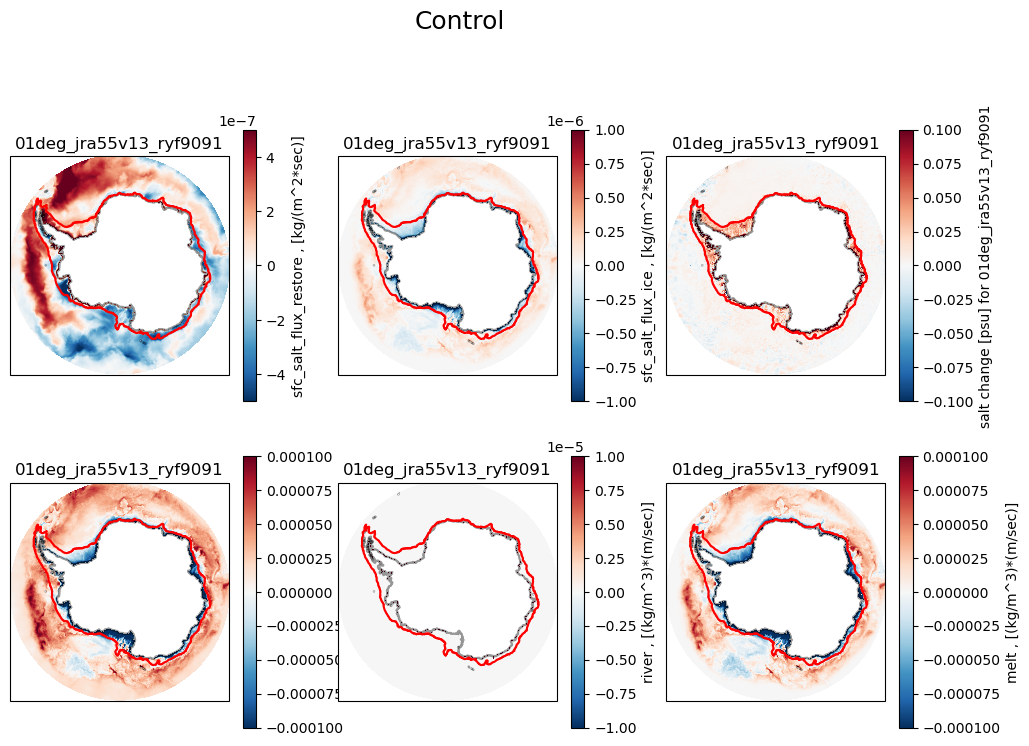

In [81]:
fig = plt.figure(figsize = (12,12))
ax = plt.subplot(3,3,1,projection=ccrs.SouthPolarStereo())
plot(ax,'sfc_salt_flux_restore',control,start_time, end_time, 5e-7)
ax = plt.subplot(3,3,2,projection=ccrs.SouthPolarStereo())
plot(ax,'sfc_salt_flux_ice',control,start_time, end_time,1e-6)
ax = plt.subplot(3,3,3,projection=ccrs.SouthPolarStereo())
plot(ax,'salt change',control,start_time, end_time,0.1)
ax = plt.subplot(3,3,4,projection=ccrs.SouthPolarStereo())
plot(ax,'pme_net',control,start_time, end_time,1e-4)
ax = plt.subplot(3,3,5,projection=ccrs.SouthPolarStereo())
plot(ax,'river',control,start_time, end_time, 1e-5)
ax = plt.subplot(3,3,6,projection=ccrs.SouthPolarStereo())
plot(ax,'melt',control,start_time, end_time, 1e-4)
fig.suptitle('Control', fontsize = 18)

/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.01/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.01/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


Text(0.5, 0.98, 'Basal - Control')

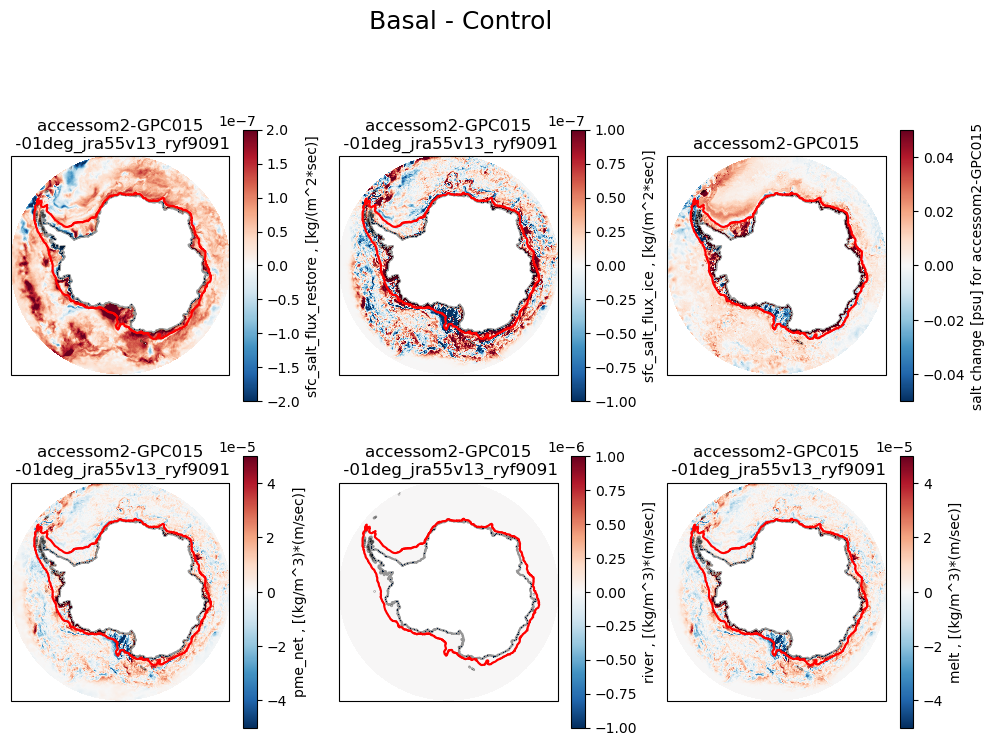

In [82]:
fig = plt.figure(figsize = (12,12))
start_timeb = '2165-01-01'
end_timeb = '2169-12-31'
ax = plt.subplot(3,3,1,projection=ccrs.SouthPolarStereo())
plot_anom(ax,'sfc_salt_flux_restore',basal,control,start_timeb, end_timeb,start_time, end_time, 2e-7)
ax = plt.subplot(3,3,2,projection=ccrs.SouthPolarStereo())
plot_anom(ax,'sfc_salt_flux_ice',basal,control,start_timeb, end_timeb,start_time, end_time,1e-7)
ax = plt.subplot(3,3,3,projection=ccrs.SouthPolarStereo())
plot(ax,'salt change',basal,start_time, end_timeb,0.05)
ax = plt.subplot(3,3,4,projection=ccrs.SouthPolarStereo())
plot_anom(ax,'pme_net',basal,control,start_timeb, end_timeb,start_time, end_time,5e-5)
ax = plt.subplot(3,3,5,projection=ccrs.SouthPolarStereo())
plot_anom(ax,'river',basal,control,start_timeb, end_timeb,start_time, end_time, 1e-6)
ax = plt.subplot(3,3,6,projection=ccrs.SouthPolarStereo())
plot_anom(ax,'melt',basal,control,start_timeb, end_timeb,start_time, end_time, 5e-5)

fig.suptitle('Basal - Control', fontsize = 18)

/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.01/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.01/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


Text(0.5, 0.98, 'Iceberg - Control')

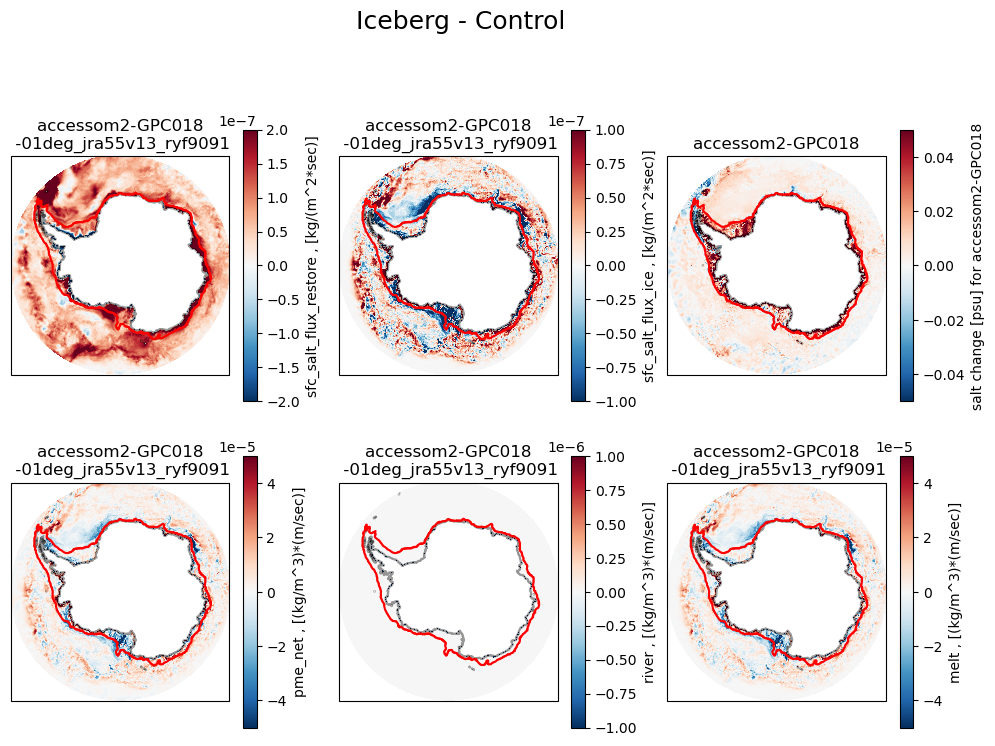

In [83]:
fig = plt.figure(figsize = (12,12))
start_timeb = '2152-01-01'
end_timeb = '2156-12-31'
ax = plt.subplot(3,3,1,projection=ccrs.SouthPolarStereo())
plot_anom(ax,'sfc_salt_flux_restore',iceberg,control,start_timeb, end_timeb,start_time, end_time, 2e-7)
ax = plt.subplot(3,3,2,projection=ccrs.SouthPolarStereo())
plot_anom(ax,'sfc_salt_flux_ice',iceberg,control,start_timeb, end_timeb,start_time, end_time,1e-7)
ax = plt.subplot(3,3,3,projection=ccrs.SouthPolarStereo())
plot(ax,'salt change',iceberg,start_time, end_timeb,0.05)
ax = plt.subplot(3,3,4,projection=ccrs.SouthPolarStereo())
plot_anom(ax,'pme_net',iceberg,control,start_timeb, end_timeb,start_time, end_time,5e-5)
ax = plt.subplot(3,3,5,projection=ccrs.SouthPolarStereo())
plot_anom(ax,'river',iceberg,control,start_timeb, end_timeb,start_time, end_time, 1e-6)
ax = plt.subplot(3,3,6,projection=ccrs.SouthPolarStereo())
plot_anom(ax,'melt',iceberg,control,start_timeb, end_timeb,start_time, end_time, 5e-5)
fig.suptitle('Iceberg - Control', fontsize = 18)

Text(0.5, 0.98, 'Iceberg - Basal yr2-7')

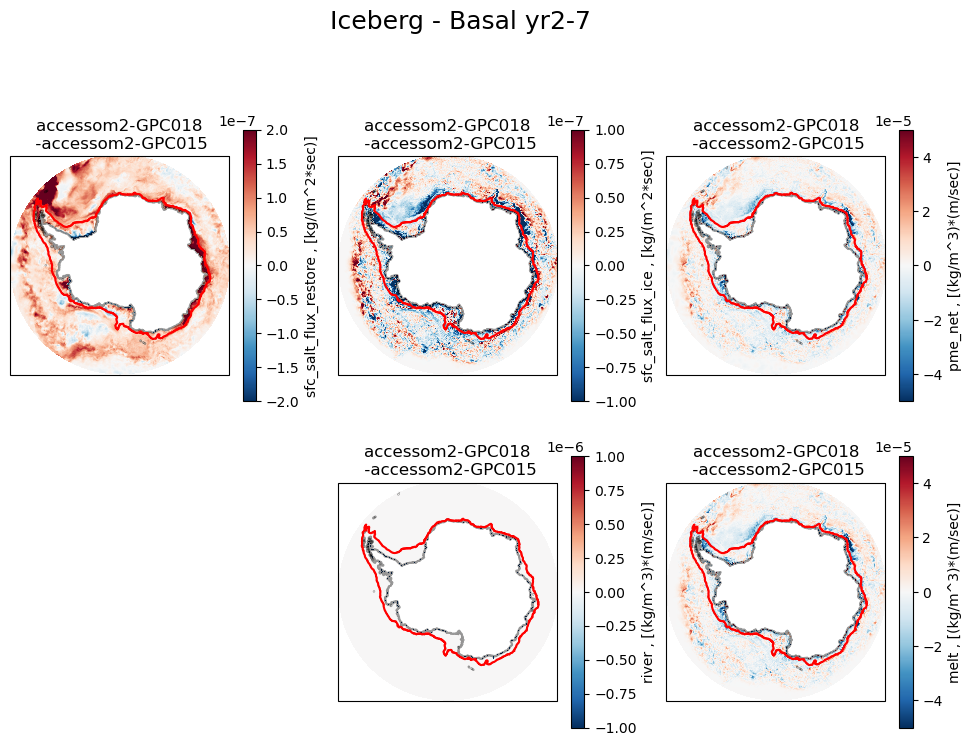

In [84]:
fig = plt.figure(figsize = (12,12))
start_timeb = '2152-01-01'
end_timeb = '2156-12-31'
ax = plt.subplot(3,3,1,projection=ccrs.SouthPolarStereo())
plot_anom(ax,'sfc_salt_flux_restore',iceberg,basal,start_timeb, end_timeb,start_timeb, end_timeb, 2e-7)
ax = plt.subplot(3,3,2,projection=ccrs.SouthPolarStereo())
plot_anom(ax,'sfc_salt_flux_ice',iceberg,basal,start_timeb, end_timeb,start_timeb, end_timeb,1e-7)
ax = plt.subplot(3,3,3,projection=ccrs.SouthPolarStereo())
plot_anom(ax,'pme_net',iceberg,basal,start_timeb, end_timeb,start_timeb, end_timeb,5e-5)
ax = plt.subplot(3,3,5,projection=ccrs.SouthPolarStereo())
plot_anom(ax,'river',iceberg,basal,start_timeb, end_timeb,start_timeb, end_timeb, 1e-6)
ax = plt.subplot(3,3,6,projection=ccrs.SouthPolarStereo())
plot_anom(ax,'melt',iceberg,basal,start_timeb, end_timeb,start_timeb, end_timeb, 5e-5)
fig.suptitle('Iceberg - Basal yr2-7', fontsize = 18)

In [ ]:
for j in np.arange(3):
    for i in np.arange(5):
        var = ['sfc_salt_flux_restore','sfc_salt_flux_ice']
        budget_ij = budget(var, expt, start_time, end_time)
    

In [ ]:
vars_025deg = cc.querying.get_variables(basal_melt_session, basal)
vars_025deg[vars_025deg['name'].str.lower().str.contains('salt')]

## Plot SWT Salt component

Code from https://github.com/COSIMA/cosima-recipes/blob/master/DocumentedExamples/Surface_Water_Mass_Transformation.ipynb

In [8]:
from gsw import alpha, SA_from_SP, p_from_z, CT_from_pt, beta, sigma1 


In [9]:
start_time = '2150-01-01'
end_time = '2154-12-31'

lat_north = -59

In [10]:
expt = basal
session = basal_melt_session


In [11]:
## getvar all required variables
SST = cc.querying.getvar(expt,'surface_temp',session,frequency='1 monthly') - 273.15 # SST - conservative temperature in K (sheck this is the case for your run)
SSS_PSU = cc.querying.getvar(expt,'surface_salt',session,frequency='1 monthly') # SSS - practical salinity (not absolute)
pme_river = cc.querying.getvar(expt,'pme_river',session,frequency='1 monthly') # mass flux of precip - evap + river
# Note that is sfc_salt_flux_ice is not saved, you can use sfc_salt_flux_ice = 0.005*melt instead
sfc_salt_flux_ice = cc.querying.getvar(expt,'sfc_salt_flux_ice',session,frequency='1 monthly') # mass flux of salt from ice formation/melt
sfc_salt_flux_restore = cc.querying.getvar(expt,'sfc_salt_flux_restore',session,frequency='1 monthly') # mass flux of salt from surface salinity restoring
## getvar the components of the net surface heat fux instead of the net_surface_heating variable
sfc_hflux_from_runoff = cc.querying.getvar(expt,'sfc_hflux_from_runoff',session,frequency='1 monthly') # W/m2
sfc_hflux_coupler = cc.querying.getvar(expt,'sfc_hflux_coupler',session,frequency='1 monthly') # W/m2
sfc_hflux_pme = cc.querying.getvar(expt,'sfc_hflux_pme',session,frequency='1 monthly') # W/m2
frazil_3d_int_z = cc.querying.getvar(expt,'frazil_3d_int_z',session,frequency='1 monthly') # W/m2
geolon_t = cc.querying.getvar(expt,'geolon_t',session, n=1)
geolat_t = cc.querying.getvar(expt,'geolat_t',session, n=1)
## slice for time and latitudinal constraints
time_slice = slice(start_time,end_time)
lat_slice = slice(-90,lat_north)
SST = SST.sel(time=time_slice, yt_ocean=lat_slice)
SSS_PSU = SSS_PSU.sel(time=time_slice, yt_ocean=lat_slice)
pme_river = pme_river.sel(time=time_slice, yt_ocean=lat_slice)
sfc_salt_flux_ice = sfc_salt_flux_ice.sel(time=time_slice, yt_ocean=lat_slice)
sfc_salt_flux_restore = sfc_salt_flux_restore.sel(time=time_slice, yt_ocean=lat_slice)
sfc_hflux_from_runoff = sfc_hflux_from_runoff.sel(time=time_slice, yt_ocean=lat_slice)
sfc_hflux_coupler = sfc_hflux_coupler.sel(time=time_slice, yt_ocean=lat_slice)
sfc_hflux_pme = sfc_hflux_pme.sel(time=time_slice, yt_ocean=lat_slice)
frazil_3d_int_z = frazil_3d_int_z.sel(time=time_slice, yt_ocean=lat_slice)
lon_t = geolon_t.sel(yt_ocean=lat_slice)
lat_t = geolat_t.sel(yt_ocean=lat_slice)
## extract coordinate arrays
yt_ocean = SST.yt_ocean.values
xt_ocean = SST.xt_ocean.values
st_ocean = cc.querying.getvar(expt,'st_ocean',session,n=1).load()
time_monthly = SST.time.values
## construct an xarray of days per month (check this is relevant to your run), simple modification if non integer number of years analysed
start_month = int(start_time[5:7])
end_month = int(end_time[5:7])
n_years = int(len(SST.time)/12)
months_standard_noleap = np.array([31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31])
if start_month != 1:
    months_offset_noleap = np.append(months_standard_noleap[(start_month-1):],months_standard_noleap[:(start_month-1)])
else:
    months_offset_noleap = months_standard_noleap
days_per_month = xr.DataArray(np.tile(months_offset_noleap, n_years), coords = [time_monthly], dims = ['time'], name = 'days per month')
## compute net surface heat flux from its component terms
net_surface_heating = sfc_hflux_from_runoff+ sfc_hflux_coupler+ sfc_hflux_pme+ frazil_3d_int_z # W/m2
## now I use some TEOS-10 gsw functions to compute absolute salinity, then potential density fields
## these are numpy functions, if you have memory errors this is a good step to check (though I have found
## this works on the VDI for 0.1 degree data, might be issues for very long time periods)
depth = -st_ocean[0].values # st_ocean value of the uppermost cell
depth_tile = (lat_t*0+1)*depth
pressure = xr.DataArray(p_from_z(depth_tile,lat_t), coords = [yt_ocean, xt_ocean], dims = ['yt_ocean', 'xt_ocean'], name = 'pressure', attrs = {'units':'dbar'})
# convert units to absolute salinity 
SSS = xr.DataArray(SA_from_SP(SSS_PSU,pressure,lon_t,lat_t), coords = [time_monthly, yt_ocean, xt_ocean], dims = ['time','yt_ocean', 'xt_ocean'], name = 'sea surface salinity', attrs = {'units':'Absolute Salinity (g/kg)'})
## SST is already saved as conservative temperature in this run, if you are working with an older run with potential 
## temperature saved, conversion will be required (make sure you work with C not K)
# SST = xr.DataArray(CT_from_pt(SSS_AS,SST_PT), coords = [time_monthly, yt_ocean, xt_ocean], dims = ['time','yt_ocean', 'xt_ocean'], name = 'sea surface temperature', attrs = {'units':'Conservative Temperature (C)'})
# compute potential density referenced to 1000dbar (or referenced otherwise, depending on your purpose)
pot_rho_1 = xr.DataArray(sigma1(SSS, SST), coords = [time_monthly, yt_ocean, xt_ocean], dims = ['time','yt_ocean', 'xt_ocean'], name = 'potential density ref 1000dbar', attrs = {'units':'kg/m^3 (-1000 kg/m^3)'})
pot_rho_1 = pot_rho_1.load()
# Compute salt transformation (no density binning)
haline_contraction = xr.DataArray(beta(SSS, SST, pressure), coords = [time_monthly, yt_ocean, xt_ocean], dims = ['time','yt_ocean', 'xt_ocean'], name = 'saline contraction coefficient (constant conservative temp)', attrs = {'units':'kg/g'})
# Note that the salt fluxes have units of (kg of salt)/m^2/s, while beta has
# units of kg / (g of salt), so we need to multiply the salt fluxes by 1000,
# the fresh water flux `pme_river` has units of (kg of water)/(m²/s) and needs
# to be multiplied by SSS to convert to (g of salt)/m^2/s
# This gives units of (kg of water)/m² for the salt_transformation but it
# will later be divided by time and density and be in m/s:
salt_transformation = haline_contraction*(SSS*pme_river-(sfc_salt_flux_ice + sfc_salt_flux_restore)*1000)*days_per_month #! before was PSU, why?
salt_transformation = salt_transformation.load()


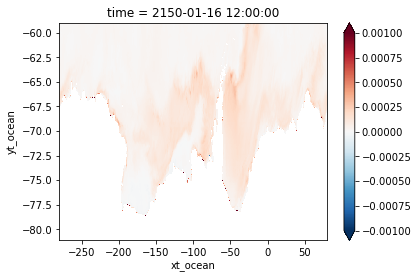

In [12]:
salt_transformation.isel(time = 0).plot(vmax = 0.001)

In [33]:
### Since basal and iceberg are 3D fields, need to compute beta coefficient for conversion between salt to FW 
### at 3D fields, not just at surface. Unfortunately this slows down computation even more. Need to work on this


# def get_salt_budget_terms_3D(expt, session, start_time, end_time, lat_north = -59):
#     '''
#     Gets surface water-mass transformation rates, copied from cosima recipes
#     https://github.com/COSIMA/cosima-recipes/blob/master/DocumentedExamples/Surface_Water_Mass_Transformation.ipynb
#     '''
#     ## getvar all required variables
#     SST = cc.querying.getvar(expt,'temp',session,frequency='1 monthly',start_time=start_time,end_time=end_time) - 273.15 # SST - conservative temperature in K (sheck this is the case for your run)
#     SSS_PSU = cc.querying.getvar(expt,'salt',session,frequency='1 monthly',start_time=start_time,end_time=end_time) # SSS - practical salinity (not absolute)
#     pme_river = cc.querying.getvar(expt,'pme_river',session,frequency='1 monthly',start_time=start_time,end_time=end_time) # mass flux of precip - evap + river
#     melt = cc.querying.getvar(expt,'melt',session,frequency='1 monthly',start_time=start_time,end_time=end_time) #
#     river = cc.querying.getvar(expt,'river',session,frequency='1 monthly',start_time=start_time,end_time=end_time) #
#     # Note that is sfc_salt_flux_ice is not saved, you can use sfc_salt_flux_ice = 0.005*melt instead
#     sfc_salt_flux_ice = cc.querying.getvar(expt,'sfc_salt_flux_ice',session,frequency='1 monthly',start_time=start_time,end_time=end_time) # mass flux of salt from ice formation/melt
#     sfc_salt_flux_restore = cc.querying.getvar(expt,'sfc_salt_flux_restore',session,frequency='1 monthly',start_time=start_time,end_time=end_time) # mass flux of salt from surface salinity restoring

#     varlist = cc.querying.get_variables(session, expt)
#     if varlist['name'].str.contains('salt_basalmix').any():
#         salt_basalmix = cc.querying.getvar(expt,'salt_basalmix',session,frequency='1 monthly',start_time=start_time,end_time=end_time) # mass flux of salt from basal flux
#     else:
#         salt_basalmix = xr.zeros_like(sfc_salt_flux_ice)
        
#     if varlist['name'].str.contains('salt_icbmix').any():
#         salt_icbmix = cc.querying.getvar(expt,'salt_icbmix',session,frequency='1 monthly',start_time=start_time,end_time=end_time) # mass flux of salt from basal flux
#     else:
#         salt_icbmix = xr.zeros_like(sfc_salt_flux_ice)
        
#     ## getvar the components of the net surface heat fux instead of the net_surface_heating variable
#     #sfc_hflux_from_runoff = cc.querying.getvar(expt,'sfc_hflux_from_runoff',session,frequency='1 monthly') # W/m2
#     #sfc_hflux_coupler = cc.querying.getvar(expt,'sfc_hflux_coupler',session,frequency='1 monthly') # W/m2
#     #sfc_hflux_pme = cc.querying.getvar(expt,'sfc_hflux_pme',session,frequency='1 monthly') # W/m2
#     #frazil_3d_int_z = cc.querying.getvar(expt,'frazil_3d_int_z',session,frequency='1 monthly') # W/m2
#     geolon_t = cc.querying.getvar(expt,'geolon_t',session, n=1)
#     geolat_t = cc.querying.getvar(expt,'geolat_t',session, n=1)
#     ## slice for time and latitudinal constraints
#     time_slice = slice(start_time,end_time)
#     lat_slice = slice(-90,lat_north)
#     SST = SST.sel(time=time_slice, yt_ocean=lat_slice)
#     SSS_PSU = SSS_PSU.sel(time=time_slice, yt_ocean=lat_slice)
#     pme_river = pme_river.sel(time=time_slice, yt_ocean=lat_slice)
#     melt = melt.sel(time=time_slice, yt_ocean=lat_slice)
#     river = river.sel(time=time_slice, yt_ocean=lat_slice)
#     sfc_salt_flux_ice = sfc_salt_flux_ice.sel(time=time_slice, yt_ocean=lat_slice)
#     sfc_salt_flux_restore = sfc_salt_flux_restore.sel(time=time_slice, yt_ocean=lat_slice)
#     salt_basalmix = salt_basalmix.sel(time=time_slice, yt_ocean=lat_slice)
#     salt_icbmix = salt_icbmix.sel(time=time_slice, yt_ocean=lat_slice)
    
#     #sfc_hflux_from_runoff = sfc_hflux_from_runoff.sel(time=time_slice, yt_ocean=lat_slice)
#     #sfc_hflux_coupler = sfc_hflux_coupler.sel(time=time_slice, yt_ocean=lat_slice)
#     #sfc_hflux_pme = sfc_hflux_pme.sel(time=time_slice, yt_ocean=lat_slice)
#     #frazil_3d_int_z = frazil_3d_int_z.sel(time=time_slice, yt_ocean=lat_slice)
#     lon_t = geolon_t.sel(yt_ocean=lat_slice)
#     lat_t = geolat_t.sel(yt_ocean=lat_slice)
#     ## extract coordinate arrays
#     yt_ocean = SSS_PSU.yt_ocean.values
#     xt_ocean = SSS_PSU.xt_ocean.values
#     st_ocean = cc.querying.getvar(expt,'st_ocean',session,n=1).load()
#     time_monthly = SSS_PSU.time.values
#     ## construct an xarray of days per month (check this is relevant to your run), simple modification if non integer number of years analysed
#     start_month = int(start_time[5:7])
#     end_month = int(end_time[5:7])
#     n_years = int(len(SSS_PSU.time)/12)
#     months_standard_noleap = np.array([31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31])
#     if start_month != 1:
#         months_offset_noleap = np.append(months_standard_noleap[(start_month-1):],months_standard_noleap[:(start_month-1)])
#     else:
#         months_offset_noleap = months_standard_noleap
#     days_per_month = xr.DataArray(np.tile(months_offset_noleap, n_years), coords = [time_monthly], dims = ['time'], name = 'days per month')
#     ## compute net surface heat flux from its component terms
#     #net_surface_heating = sfc_hflux_from_runoff+ sfc_hflux_coupler+ sfc_hflux_pme+ frazil_3d_int_z # W/m2
#     ## now I use some TEOS-10 gsw functions to compute absolute salinity, then potential density fields
#     ## these are numpy functions, if you have memory errors this is a good step to check (though I have found
#     ## this works on the VDI for 0.1 degree data, might be issues for very long time periods)
#     depth = -st_ocean # st_ocean value of the uppermost cell
#     depth_tile = (SST.isel(time = 0)*0+1)*depth
#     lat_t = (SST.isel(time = 0)*0+1)*lat_t
#     lon_t = (SST.isel(time = 0)*0+1)*lon_t
    
#     pressure = xr.DataArray(p_from_z(depth_tile,lat_t), coords = [st_ocean,yt_ocean, xt_ocean], dims = ['st_ocean','yt_ocean', 'xt_ocean'], name = 'pressure', attrs = {'units':'dbar'})
#     # convert units to absolute salinity 
#     SSS = xr.DataArray(SA_from_SP(SSS_PSU,pressure,lon_t,lat_t), coords = [time_monthly,st_ocean, yt_ocean, xt_ocean], dims = ['time','st_ocean','yt_ocean', 'xt_ocean'], name = 'sea surface salinity', attrs = {'units':'Absolute Salinity (g/kg)'})
#     ## SST is already saved as conservative temperature in this run, if you are working with an older run with potential 
#     ## temperature saved, conversion will be required (make sure you work with C not K)
#     # SST = xr.DataArray(CT_from_pt(SSS_AS,SST_PT), coords = [time_monthly, yt_ocean, xt_ocean], dims = ['time','yt_ocean', 'xt_ocean'], name = 'sea surface temperature', attrs = {'units':'Conservative Temperature (C)'})
#     # compute potential density referenced to 1000dbar (or referenced otherwise, depending on your purpose)
#     #pot_rho_1 = xr.DataArray(sigma1(SSS, SST), coords = [time_monthly, yt_ocean, xt_ocean], dims = ['time','yt_ocean', 'xt_ocean'], name = 'potential density ref 1000dbar', attrs = {'units':'kg/m^3 (-1000 kg/m^3)'})
#     #pot_rho_1 = pot_rho_1.load()
#     # Compute salt transformation (no density binning)
#     haline_contraction = xr.DataArray(beta(SSS, SST, pressure), coords = [time_monthly, st_ocean, yt_ocean, xt_ocean], dims = ['time','st_ocean','yt_ocean', 'xt_ocean'], name = 'saline contraction coefficient (constant conservative temp)', attrs = {'units':'kg/g'})
#     # Note that the salt fluxes have units of (kg of salt)/m^2/s, while beta has
#     # units of kg / (g of salt), so we need to multiply the salt fluxes by 1000,
#     # the fresh water flux `pme_river` has units of (kg of water)/(m²/s) and needs
#     # to be multiplied by SSS to convert to (g of salt)/m^2/s
#     # This gives units of (kg of water)/m² for the salt_transformation but it
#     # will later be divided by time and density and be in m/s:
#     #salt_transformation = haline_contraction*(SSS*pme_river-(sfc_salt_flux_ice + sfc_salt_flux_restore + salt_basalmix + salt_icbmix)*1000)*days_per_month #! before was PSU, why?
#     #salt_transformation = salt_transformation.load()
    
#     haline_contraction = haline_contraction.load()
    
#     pme_river_salt_trans = haline_contraction.isel(st_ocean = 0)*SSS.isel(st_ocean = 0)*pme_river*days_per_month
#     pme_river_salt_trans = pme_river_salt_trans.load()

#     river = haline_contraction.isel(st_ocean = 0)*SSS.isel(st_ocean = 0)*river*days_per_month
#     river = river.load()

#     melt = haline_contraction.isel(st_ocean = 0)*SSS.isel(st_ocean = 0)*melt*days_per_month
#     melt = melt.load()
    
#     ice = haline_contraction.isel(st_ocean = 0)*sfc_salt_flux_ice*1000*days_per_month
#     ice = ice.load()
    
#     restore = haline_contraction.isel(st_ocean = 0)*sfc_salt_flux_restore*1000*days_per_month
#     restore = restore.load()
    
#     basal = haline_contraction*salt_basalmix*1000*days_per_month
#     basal = basal.load()
    
#     icb = haline_contraction*salt_icbmix*1000*days_per_month
#     icb = icb.load()
    
    
    
#     return pme_river_salt_trans, river, melt, ice, restore, basal, icb, days_per_month


In [37]:
def get_salt_budget_terms(expt, session, start_time, end_time, lat_north = -59):
    '''
    Gets surface water-mass transformation rates, copied from cosima recipes
    https://github.com/COSIMA/cosima-recipes/blob/master/DocumentedExamples/Surface_Water_Mass_Transformation.ipynb
    '''
    ## getvar all required variables
    SST = cc.querying.getvar(expt,'surface_temp',session,frequency='1 monthly',start_time=start_time,end_time=end_time) - 273.15 # SST - conservative temperature in K (sheck this is the case for your run)
    SSS_PSU = cc.querying.getvar(expt,'surface_salt',session,frequency='1 monthly',start_time=start_time,end_time=end_time) # SSS - practical salinity (not absolute)
    pme_river = cc.querying.getvar(expt,'pme_river',session,frequency='1 monthly',start_time=start_time,end_time=end_time) # mass flux of precip - evap + river
    melt = cc.querying.getvar(expt,'melt',session,frequency='1 monthly',start_time=start_time,end_time=end_time) #
    river = cc.querying.getvar(expt,'river',session,frequency='1 monthly',start_time=start_time,end_time=end_time) #
    # Note that is sfc_salt_flux_ice is not saved, you can use sfc_salt_flux_ice = 0.005*melt instead
    sfc_salt_flux_ice = cc.querying.getvar(expt,'sfc_salt_flux_ice',session,frequency='1 monthly',start_time=start_time,end_time=end_time) # mass flux of salt from ice formation/melt
    sfc_salt_flux_restore = cc.querying.getvar(expt,'sfc_salt_flux_restore',session,frequency='1 monthly',start_time=start_time,end_time=end_time) # mass flux of salt from surface salinity restoring

    varlist = cc.querying.get_variables(session, expt)
    if varlist['name'].str.contains('salt_basalmix').any():
        salt_basalmix = cc.querying.getvar(expt,'salt_basalmix',session,frequency='1 monthly',start_time=start_time,end_time=end_time) # mass flux of salt from basal flux
    else:
        salt_basalmix = xr.zeros_like(sfc_salt_flux_ice)
        
    if varlist['name'].str.contains('salt_icbmix').any():
        salt_icbmix = cc.querying.getvar(expt,'salt_icbmix',session,frequency='1 monthly',start_time=start_time,end_time=end_time) # mass flux of salt from basal flux
    else:
        salt_icbmix = xr.zeros_like(sfc_salt_flux_ice)
        
    ## getvar the components of the net surface heat fux instead of the net_surface_heating variable
    #sfc_hflux_from_runoff = cc.querying.getvar(expt,'sfc_hflux_from_runoff',session,frequency='1 monthly') # W/m2
    #sfc_hflux_coupler = cc.querying.getvar(expt,'sfc_hflux_coupler',session,frequency='1 monthly') # W/m2
    #sfc_hflux_pme = cc.querying.getvar(expt,'sfc_hflux_pme',session,frequency='1 monthly') # W/m2
    #frazil_3d_int_z = cc.querying.getvar(expt,'frazil_3d_int_z',session,frequency='1 monthly') # W/m2
    geolon_t = cc.querying.getvar(expt,'geolon_t',session, n=1)
    geolat_t = cc.querying.getvar(expt,'geolat_t',session, n=1)
    ## slice for time and latitudinal constraints
    time_slice = slice(start_time,end_time)
    lat_slice = slice(-90,lat_north)
    SST = SST.sel(time=time_slice, yt_ocean=lat_slice)
    SSS_PSU = SSS_PSU.sel(time=time_slice, yt_ocean=lat_slice)
    pme_river = pme_river.sel(time=time_slice, yt_ocean=lat_slice)
    melt = melt.sel(time=time_slice, yt_ocean=lat_slice)
    river = river.sel(time=time_slice, yt_ocean=lat_slice)
    sfc_salt_flux_ice = sfc_salt_flux_ice.sel(time=time_slice, yt_ocean=lat_slice)
    sfc_salt_flux_restore = sfc_salt_flux_restore.sel(time=time_slice, yt_ocean=lat_slice)
    salt_basalmix = salt_basalmix.sel(time=time_slice, yt_ocean=lat_slice)
    salt_icbmix = salt_icbmix.sel(time=time_slice, yt_ocean=lat_slice)
    
    #sfc_hflux_from_runoff = sfc_hflux_from_runoff.sel(time=time_slice, yt_ocean=lat_slice)
    #sfc_hflux_coupler = sfc_hflux_coupler.sel(time=time_slice, yt_ocean=lat_slice)
    #sfc_hflux_pme = sfc_hflux_pme.sel(time=time_slice, yt_ocean=lat_slice)
    #frazil_3d_int_z = frazil_3d_int_z.sel(time=time_slice, yt_ocean=lat_slice)
    lon_t = geolon_t.sel(yt_ocean=lat_slice)
    lat_t = geolat_t.sel(yt_ocean=lat_slice)
    ## extract coordinate arrays
    yt_ocean = SSS_PSU.yt_ocean.values
    xt_ocean = SSS_PSU.xt_ocean.values
    st_ocean = cc.querying.getvar(expt,'st_ocean',session,n=1).load()
    time_monthly = SSS_PSU.time.values
    ## construct an xarray of days per month (check this is relevant to your run), simple modification if non integer number of years analysed
    start_month = int(start_time[5:7])
    end_month = int(end_time[5:7])
    n_years = int(len(SSS_PSU.time)/12)
    months_standard_noleap = np.array([31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31])
    if start_month != 1:
        months_offset_noleap = np.append(months_standard_noleap[(start_month-1):],months_standard_noleap[:(start_month-1)])
    else:
        months_offset_noleap = months_standard_noleap
    days_per_month = xr.DataArray(np.tile(months_offset_noleap, n_years), coords = [time_monthly], dims = ['time'], name = 'days per month')
    ## compute net surface heat flux from its component terms
    #net_surface_heating = sfc_hflux_from_runoff+ sfc_hflux_coupler+ sfc_hflux_pme+ frazil_3d_int_z # W/m2
    ## now I use some TEOS-10 gsw functions to compute absolute salinity, then potential density fields
    ## these are numpy functions, if you have memory errors this is a good step to check (though I have found
    ## this works on the VDI for 0.1 degree data, might be issues for very long time periods)
    depth = -st_ocean[0].values # st_ocean value of the uppermost cell
    depth_tile = (lat_t*0+1)*depth
    pressure = xr.DataArray(p_from_z(depth_tile,lat_t), coords = [yt_ocean, xt_ocean], dims = ['yt_ocean', 'xt_ocean'], name = 'pressure', attrs = {'units':'dbar'})
    # convert units to absolute salinity 
    SSS = xr.DataArray(SA_from_SP(SSS_PSU,pressure,lon_t,lat_t), coords = [time_monthly, yt_ocean, xt_ocean], dims = ['time','yt_ocean', 'xt_ocean'], name = 'sea surface salinity', attrs = {'units':'Absolute Salinity (g/kg)'})
    ## SST is already saved as conservative temperature in this run, if you are working with an older run with potential 
    ## temperature saved, conversion will be required (make sure you work with C not K)
    # SST = xr.DataArray(CT_from_pt(SSS_AS,SST_PT), coords = [time_monthly, yt_ocean, xt_ocean], dims = ['time','yt_ocean', 'xt_ocean'], name = 'sea surface temperature', attrs = {'units':'Conservative Temperature (C)'})
    # compute potential density referenced to 1000dbar (or referenced otherwise, depending on your purpose)
    #pot_rho_1 = xr.DataArray(sigma1(SSS, SST), coords = [time_monthly, yt_ocean, xt_ocean], dims = ['time','yt_ocean', 'xt_ocean'], name = 'potential density ref 1000dbar', attrs = {'units':'kg/m^3 (-1000 kg/m^3)'})
    #pot_rho_1 = pot_rho_1.load()
    # Compute salt transformation (no density binning)
    haline_contraction = xr.DataArray(beta(SSS, SST, pressure), coords = [time_monthly, yt_ocean, xt_ocean], dims = ['time','yt_ocean', 'xt_ocean'], name = 'saline contraction coefficient (constant conservative temp)', attrs = {'units':'kg/g'})
    # Note that the salt fluxes have units of (kg of salt)/m^2/s, while beta has
    # units of kg / (g of salt), so we need to multiply the salt fluxes by 1000,
    # the fresh water flux `pme_river` has units of (kg of water)/(m²/s) and needs
    # to be multiplied by SSS to convert to (g of salt)/m^2/s
    # This gives units of (kg of water)/m² for the salt_transformation but it
    # will later be divided by time and density and be in m/s:
    #salt_transformation = haline_contraction*(SSS*pme_river-(sfc_salt_flux_ice + sfc_salt_flux_restore + salt_basalmix + salt_icbmix)*1000)*days_per_month #! before was PSU, why?
    #salt_transformation = salt_transformation.load()
    
    haline_contraction = haline_contraction.load()
    
    pme_river_salt_trans = haline_contraction*SSS*pme_river*days_per_month
    pme_river_salt_trans = pme_river_salt_trans.load()

    river = haline_contraction*SSS*river*days_per_month
    river = river.load()

    melt = haline_contraction*SSS*melt*days_per_month
    melt = melt.load()
    
    ice = haline_contraction*sfc_salt_flux_ice*1000*days_per_month
    ice = ice.load()
    
    restore = haline_contraction*sfc_salt_flux_restore*1000*days_per_month
    restore = restore.load()
    
    basal = haline_contraction*salt_basalmix*1000*days_per_month
    basal = basal.load()
    
    icb = haline_contraction*salt_icbmix*1000*days_per_month
    icb = icb.load()
    
    
    
    return pme_river_salt_trans, river, melt, ice, restore, basal, icb, days_per_month


Maybe need `salt_basalmix` and `salt_icbmix` too

In [ ]:
## Global

start_time = '2155-01-01'
end_time = '2155-12-31'
session = master_session
expt = control
lat_north = 90
area_t = cc.querying.getvar(expt, 'area_t', session, n=1).sel(yt_ocean = slice(-90,lat_north))

bar_plot = np.zeros((3,5))

for i in np.arange(1):
    print(i)
    expt = [control,basal,iceberg][i]
    session = [master_session,basal_melt_session,basal_melt_session][i]
    
    pme_river_salt_trans,river,melt,ice,restore,basalh,icb,days_per_month = get_salt_budget_terms(expt, session, start_time, end_time, lat_north)
    ndays = days_per_month.sum().values
    bar_plot[i,:]=[#(salt_transformation*area_t).sum()/ndays,
                   (pme_river_salt_trans*area_t).sum()/ndays,
                   -(ice*area_t).sum()/ndays,
                   -(restore*area_t).sum()/ndays,
                   -(basalh*area_t).sum()/ndays,
                   -(icb*area_t).sum()/ndays                   
                  ]

X = np.arange(5)
fig = plt.figure(figsize = (10,4))
ax = fig.add_axes([0,0,1,1])

ax.bar(X + 0.00, bar_plot[0,:], color = 'orangered', width = 0.25)
ax.bar(X + 0.25, bar_plot[1,:], color = 'mediumorchid', width = 0.25)
ax.bar(X + 0.50, bar_plot[2,:], color = 'cornflowerblue', width = 0.25)
ax.legend(labels=['control', 'basal','iceberg'])
plt.xticks(X+0.25, ('pme_river','ice','restore','basal','iceberg'))
plt.title('Global freshwater budget (kg/s)')


2023-03-20 13:06:06,772 - distributed.nanny - WARNING - Restarting worker
2023-03-20 13:06:06,844 - distributed.nanny - WARNING - Restarting worker


Text(0.5, 1.0, 'Global freshwater budget (kg/s)')

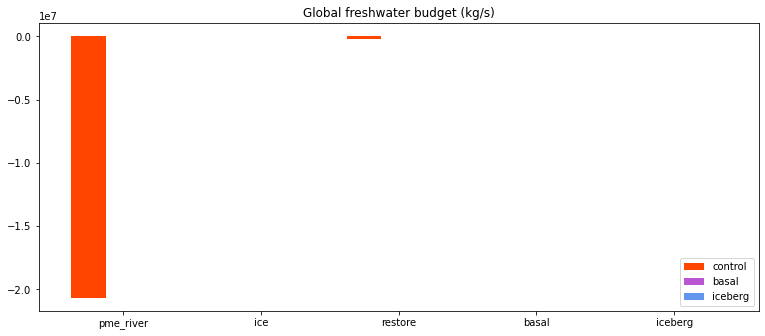

2023-03-20 13:06:23,757 - distributed.nanny - WARNING - Worker process still alive after 3.1999987792968754 seconds, killing
2023-03-20 13:06:23,758 - distributed.nanny - WARNING - Worker process still alive after 3.1999989318847657 seconds, killing
2023-03-20 13:06:23,761 - distributed.nanny - WARNING - Worker process still alive after 3.1999987792968754 seconds, killing
2023-03-20 13:06:23,762 - distributed.nanny - WARNING - Worker process still alive after 3.1999992370605472 seconds, killing
2023-03-20 13:06:23,763 - distributed.nanny - WARNING - Worker process still alive after 3.1999992370605472 seconds, killing
2023-03-20 13:06:23,765 - distributed.nanny - WARNING - Worker process still alive after 3.199998474121094 seconds, killing
2023-03-20 13:06:23,766 - distributed.nanny - WARNING - Worker process still alive after 3.1999987792968754 seconds, killing


In [39]:
X = np.arange(5)
fig = plt.figure(figsize = (10,4))
ax = fig.add_axes([0,0,1,1])

ax.bar(X + 0.00, bar_plot[0,:], color = 'orangered', width = 0.25)
ax.bar(X + 0.25, bar_plot[1,:], color = 'mediumorchid', width = 0.25)
ax.bar(X + 0.50, bar_plot[2,:], color = 'cornflowerblue', width = 0.25)
ax.legend(labels=['control', 'basal','iceberg'])
plt.xticks(X+0.25, ('pme_river','ice','restore','basal','iceberg'))
plt.title('Global freshwater budget (kg/s)')


In [40]:
bar_plot

array([[-20661577.78960356,     27222.04987717,   -225273.10836503,
               -0.        ,        -0.        ],
       [        0.        ,         0.        ,         0.        ,
                0.        ,         0.        ],
       [        0.        ,         0.        ,         0.        ,
                0.        ,         0.        ]])

In [46]:
20661577/225273.10836503

91.71790254929236

In [34]:
%%time
## Shelf 3D

start_time = '2155-01-01'
end_time = '2155-12-31'
lat_north = -59
session = master_session
expt = control
area_t = cc.querying.getvar(expt, 'area_t', session, n = 1).sel(yt_ocean = slice(-90,lat_north))

bar_plot = np.zeros((3,7))

for i in np.arange(3):
    print(i)
    expt = [control,basal,iceberg][i]
    session = [master_session,basal_melt_session,basal_melt_session][i]
    
    pme_river_salt_trans,river,melt,ice,restore,basalh,icb,days_per_month = get_salt_budget_terms_3D(expt, session, start_time, end_time, lat_north)
    ndays = days_per_month.sum().values
    pme_river_salt_trans_shelf, shelf_mask = shelf_mask_isobath(pme_river_salt_trans)
    ice_shelf, shelf_mask = shelf_mask_isobath(ice)
    restore_shelf, shelf_mask = shelf_mask_isobath(restore)
    basal_shelf, shelf_mask = shelf_mask_isobath(basalh)
    icb_shelf, shelf_mask = shelf_mask_isobath(icb)
    
    
    bar_plot[i,:]=[#(salt_transformation_shelf*area_t).sum()/ndays,
                   (pme_river_salt_trans_shelf*area_t).sum()/ndays,
                   (river*area_t).sum()/ndays,
                   (melt*area_t).sum()/ndays,        
                   -(ice_shelf*area_t).sum()/ndays,
                   -(restore_shelf*area_t).sum()/ndays,
                   -(basal_shelf*area_t).sum()/ndays,
                   -(icb_shelf*area_t).sum()/ndays
                  ]
print(bar_plot)
X = np.arange(7)
fig = plt.figure(figsize = (10,4))
ax = fig.add_axes([0,0,1,1])

ax.bar(X + 0.00, bar_plot[0,:], color = 'orangered', width = 0.25)
ax.bar(X + 0.25, bar_plot[1,:], color = 'mediumorchid', width = 0.25)
ax.bar(X + 0.50, bar_plot[2,:], color = 'cornflowerblue', width = 0.25)
ax.legend(labels=['control', 'basal','iceberg'])
plt.xticks(X+0.25, ('pme_river','ice','restore','basal','iceberg'))
plt.title('Antarctic shelf freshwater budget (kg/s)')


0


2023-03-20 11:53:44,177 - distributed.worker_memory - WARNING - Worker is at 84% memory usage. Pausing worker.  Process memory: 30.18 GiB -- Worker memory limit: 35.71 GiB
2023-03-20 11:53:44,177 - distributed.worker_memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 30.18 GiB -- Worker memory limit: 35.71 GiB
2023-03-20 11:53:44,228 - distributed.worker_memory - WARNING - Worker is at 35% memory usage. Resuming worker. Process memory: 12.64 GiB -- Worker memory limit: 35.71 GiB
2023-03-20 11:55:27,510 - distributed.worker_memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanage

1


2023-03-20 12:07:40,968 - distributed.worker_memory - WARNING - Worker tcp://127.0.0.1:33891 (pid=1235372) exceeded 95% memory budget. Restarting...
2023-03-20 12:07:42,419 - distributed.worker - ERROR - Worker stream died during communication: tcp://127.0.0.1:33891
Traceback (most recent call last):
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.07/lib/python3.9/site-packages/distributed/comm/tcp.py", line 235, in read
    n = await stream.read_into(chunk)
tornado.iostream.StreamClosedError: Stream is closed

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.07/lib/python3.9/site-packages/distributed/worker.py", line 2050, in gather_dep
    response = await get_data_from_worker(
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.07/lib/python3.9/site-packages/distributed/worker.py", line 2839, in get_data_from_worker
    return await retry_operati

KeyError: "('array-5775a5cdba491715b53b2a26c14b858f', 0, 0, 0, 0)"

In [36]:
bar_plot

array([[-3364270.42769082,  2228459.63021663,  -662283.89580547,
          883195.93465997,    64796.96641641,       -0.        ,
              -0.        ],
       [       0.        ,        0.        ,        0.        ,
               0.        ,        0.        ,        0.        ,
               0.        ],
       [       0.        ,        0.        ,        0.        ,
               0.        ,        0.        ,        0.        ,
               0.        ]])

## Old with 2D beta

0
1


2023-03-20 10:56:13,638 - distributed.worker_memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 25.01 GiB -- Worker memory limit: 35.71 GiB
2023-03-20 10:56:18,298 - distributed.worker_memory - WARNING - Worker is at 84% memory usage. Pausing worker.  Process memory: 30.11 GiB -- Worker memory limit: 35.71 GiB
2023-03-20 10:56:18,809 - distributed.worker_memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 31.46 GiB -- Worker memory limit: 35.71 GiB
2023-03-20 10:56:19,857 - distributed.worker_memory - WARNING - Worker is at 52% memory usage. Resuming worker. Proces

2


2023-03-20 11:02:33,998 - distributed.worker_memory - WARNING - Worker is at 83% memory usage. Pausing worker.  Process memory: 29.85 GiB -- Worker memory limit: 35.71 GiB
2023-03-20 11:02:35,337 - distributed.worker_memory - WARNING - Worker is at 70% memory usage. Resuming worker. Process memory: 25.01 GiB -- Worker memory limit: 35.71 GiB
2023-03-20 11:03:09,317 - distributed.worker_memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 28.47 GiB -- Worker memory limit: 35.71 GiB
2023-03-20 11:03:50,634 - distributed.worker_memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanage

[[-3364270.42769183  2228459.63021731  -662283.89580569   883195.93466024
     64796.96641643       -0.               -0.        ]
 [-5353612.24509377  1096414.30585566  -866542.17067688  1007953.26329434
    -25959.09682105  1221562.63287644       -0.        ]
 [-6902545.59290851        0.         -1058700.67550349  1076736.30261142
   -177034.33657965  1222458.19963593   630850.24206127]]


ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (5,) and arg 1 with shape (7,).

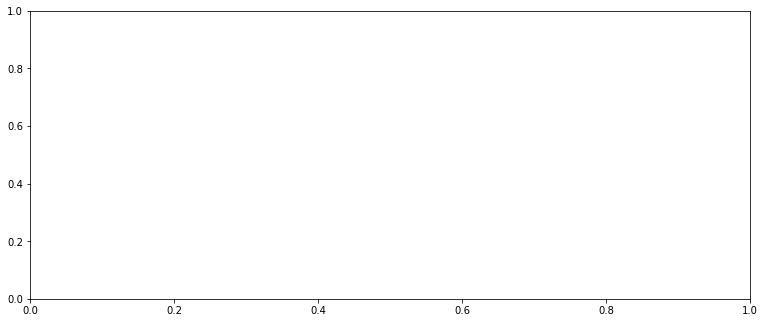

In [17]:
## Shelf

start_time = '2155-01-01'
end_time = '2155-12-31'
lat_north = -59
session = master_session
expt = control
area_t = cc.querying.getvar(expt, 'area_t', session, n = 1).sel(yt_ocean = slice(-90,lat_north))

bar_plot = np.zeros((3,7))

for i in np.arange(3):
    print(i)
    expt = [control,basal,iceberg][i]
    session = [master_session,basal_melt_session,basal_melt_session][i]
    
    pme_river_salt_trans,river,melt,ice,restore,basalh,icb,days_per_month = get_salt_budget_terms(expt, session, start_time, end_time, lat_north)
    ndays = days_per_month.sum().values
    pme_river_salt_trans_shelf, shelf_mask = shelf_mask_isobath(pme_river_salt_trans)
    ice_shelf, shelf_mask = shelf_mask_isobath(ice)
    restore_shelf, shelf_mask = shelf_mask_isobath(restore)
    basal_shelf, shelf_mask = shelf_mask_isobath(basalh)
    icb_shelf, shelf_mask = shelf_mask_isobath(icb)
    
    
    bar_plot[i,:]=[#(salt_transformation_shelf*area_t).sum()/ndays,
                   (pme_river_salt_trans_shelf*area_t).sum()/ndays,
                   (river*area_t).sum()/ndays,
                   (melt*area_t).sum()/ndays,        
                   -(ice_shelf*area_t).sum()/ndays,
                   -(restore_shelf*area_t).sum()/ndays,
                   -(basal_shelf*area_t).sum()/ndays,
                   -(icb_shelf*area_t).sum()/ndays
                  ]
print(bar_plot)
X = np.arange(5)
fig = plt.figure(figsize = (10,4))
ax = fig.add_axes([0,0,1,1])

ax.bar(X + 0.00, bar_plot[0,:], color = 'orangered', width = 0.25)
ax.bar(X + 0.25, bar_plot[1,:], color = 'mediumorchid', width = 0.25)
ax.bar(X + 0.50, bar_plot[2,:], color = 'cornflowerblue', width = 0.25)
ax.legend(labels=['control', 'basal','iceberg'])
plt.xticks(X+0.25, ('pme_river','ice','restore','basal','iceberg'))
plt.title('Antarctic shelf freshwater budget (kg/s)')


In [21]:
bar_plot

array([[-3364270.42769183,  2228459.63021731,  -662283.89580569,
          883195.93466024,    64796.96641643,       -0.        ,
              -0.        ],
       [-5353612.24509377,  1096414.30585566,  -866542.17067688,
         1007953.26329434,   -25959.09682105,  1221562.63287644,
              -0.        ],
       [-6902545.59290851,        0.        , -1058700.67550349,
         1076736.30261142,  -177034.33657965,  1222458.19963593,
          630850.24206127]])

Text(0.5, 1.0, 'Antarctic shelf freshwater budget (kg/s)')

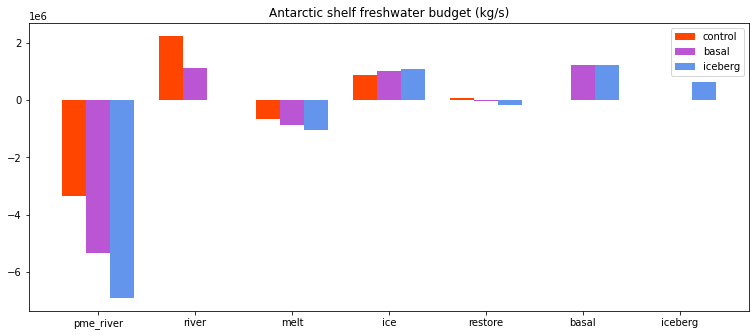

In [18]:
X = np.arange(7)
fig = plt.figure(figsize = (10,4))
ax = fig.add_axes([0,0,1,1])

ax.bar(X + 0.00, bar_plot[0,:], color = 'orangered', width = 0.25)
ax.bar(X + 0.25, bar_plot[1,:], color = 'mediumorchid', width = 0.25)
ax.bar(X + 0.50, bar_plot[2,:], color = 'cornflowerblue', width = 0.25)
ax.legend(labels=['control', 'basal','iceberg'])
plt.xticks(X+0.25, ('pme_river','river','melt','ice','restore','basal','iceberg'))
plt.title('Antarctic shelf freshwater budget (kg/s)')


In [22]:
bar_plot_copy = np.zeros((3,8))
bar_plot_copy[:,0] = bar_plot[:,0]-bar_plot[:,1]-bar_plot[:,2] #pme_river - melt - river
bar_plot_copy[:,1] = bar_plot[:,1]#river
bar_plot_copy[:,2] = bar_plot[:,2]#melt
bar_plot_copy[:,3] = bar_plot[:,3]#ice
bar_plot_copy[:,4] = bar_plot[:,4]#restore
bar_plot_copy[:,5] = bar_plot[:,5]#basal
bar_plot_copy[:,6] = bar_plot[:,6]#iceberg
bar_plot_copy[:,7] = bar_plot[:,0]+bar_plot[:,3]+bar_plot[:,4]+bar_plot[:,5]+bar_plot[:,6]#total


Text(0.5, 1.0, 'Antarctic shelf freshwater budget (kg/s)')

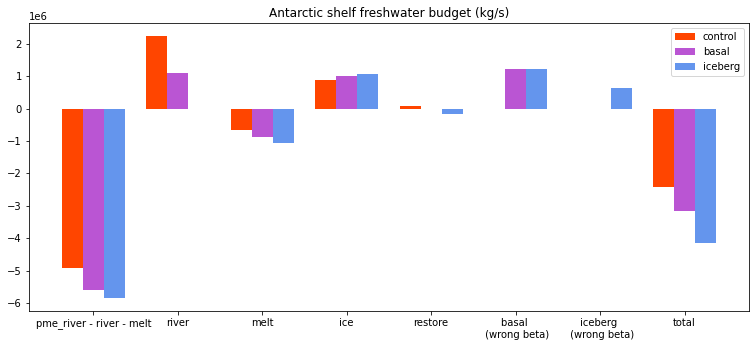

In [24]:
X = np.arange(8)
fig = plt.figure(figsize = (10,4))
ax = fig.add_axes([0,0,1,1])

ax.bar(X + 0.00, bar_plot_copy[0,:], color = 'orangered', width = 0.25)
ax.bar(X + 0.25, bar_plot_copy[1,:], color = 'mediumorchid', width = 0.25)
ax.bar(X + 0.50, bar_plot_copy[2,:], color = 'cornflowerblue', width = 0.25)
ax.legend(labels=['control', 'basal','iceberg'])
plt.xticks(X+0.25, ('pme_river - river - melt','river','melt','ice','restore','basal \n (wrong beta)','iceberg \n (wrong beta)','total'))
plt.title('Antarctic shelf freshwater budget (kg/s)')


# Zoom in on Amundsen

(0.0, 1.0, 0.0, 1.0)

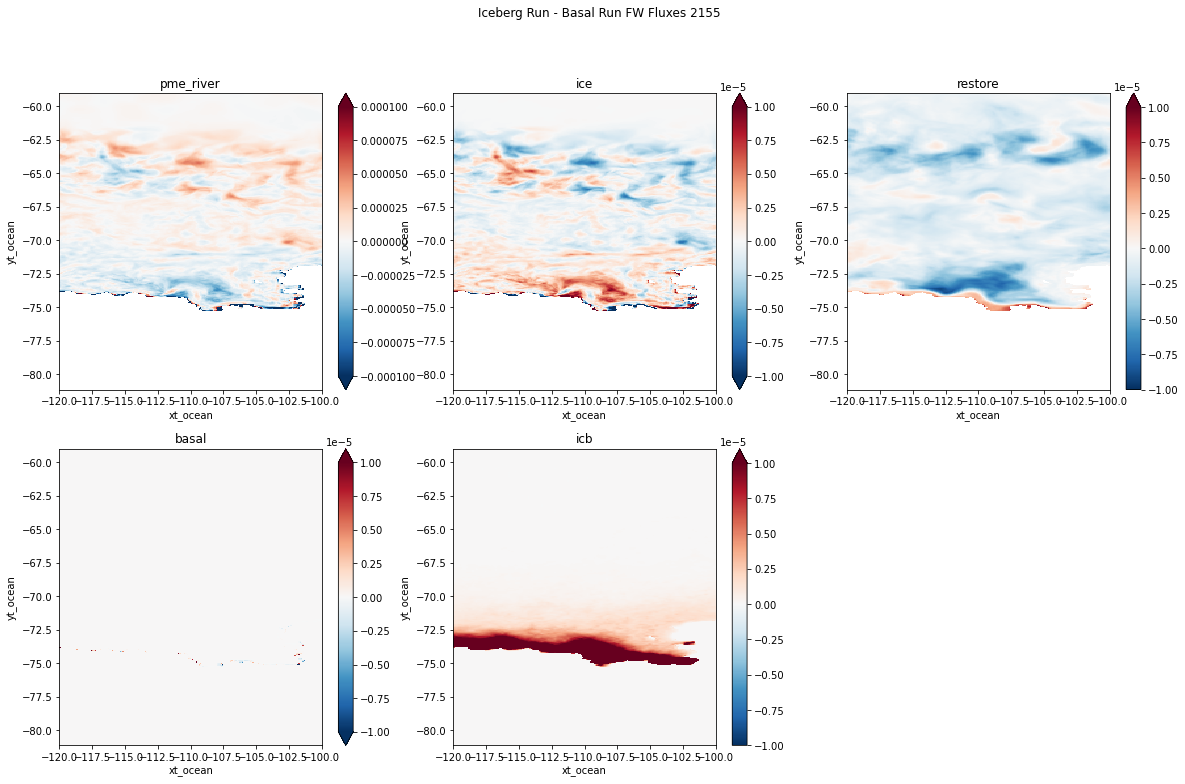

Process Dask Worker process (from Nanny):
Process Dask Worker process (from Nanny):
Process Dask Worker process (from Nanny):
Process Dask Worker process (from Nanny):
Traceback (most recent call last):
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.07/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.07/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.07/lib/python3.9/site-packages/distributed/process.py", line 188, in _run
    target(*args, **kwargs)
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.07/lib/python3.9/site-packages/distributed/nanny.py", line 981, in _run
    asyncio.run(run())
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.07/lib/python3.9/asyncio/runners.py", line 44, in run
    return loop.run_until_complete(main)
  File

In [29]:
session = basal_melt_session
expt = iceberg
start_time = '2155-01-01'
end_time = '2155-12-31'
lat_north = -59

pme_river_salt_trans,ice,restore,basalh,icb,days_per_month = get_salt_budget_terms(expt, session, start_time, end_time, lat_north)

expt = basal
pme_river_salt_trans2,ice2,restore2,basalh2,icb2,days_per_month2 = get_salt_budget_terms(expt, session, start_time, end_time, lat_north)

fig,axes = plt.subplots(nrows = 2, ncols = 3, figsize = (20,12))
(pme_river_salt_trans-pme_river_salt_trans2).sel(xt_ocean = slice(-120,-100)).mean('time').plot(ax = axes[0,0], vmin = -1e-4, vmax = 1e-4,cmap = 'RdBu_r')
axes[0,0].set_title('pme_river')
(-(ice-ice2)).sel(xt_ocean = slice(-120,-100)).mean('time').plot(ax = axes[0,1], vmin = -1e-5, vmax = 1e-5,cmap = 'RdBu_r')
axes[0,1].set_title('ice')
(-(restore-restore2)).sel(xt_ocean = slice(-120,-100)).mean('time').plot(ax = axes[0,2], vmin = -1e-5, vmax = 1e-5,cmap = 'RdBu_r')
axes[0,2].set_title('restore')
(-(basalh-basalh2)).sel(xt_ocean = slice(-120,-100)).sum('st_ocean').mean('time').plot(ax = axes[1,0], vmin = -1e-5, vmax = 1e-5,cmap = 'RdBu_r')
axes[1,0].set_title('basal')
(-(icb-icb2)).sel(xt_ocean = slice(-120,-100)).sum('st_ocean').mean('time').plot(ax = axes[1,1], vmin = -1e-5, vmax = 1e-5,cmap = 'RdBu_r')
axes[1,1].set_title('icb')
fig.suptitle('Iceberg Run - Basal Run FW Fluxes 2155')
axes[1,2].axis('off')


(0.0, 1.0, 0.0, 1.0)

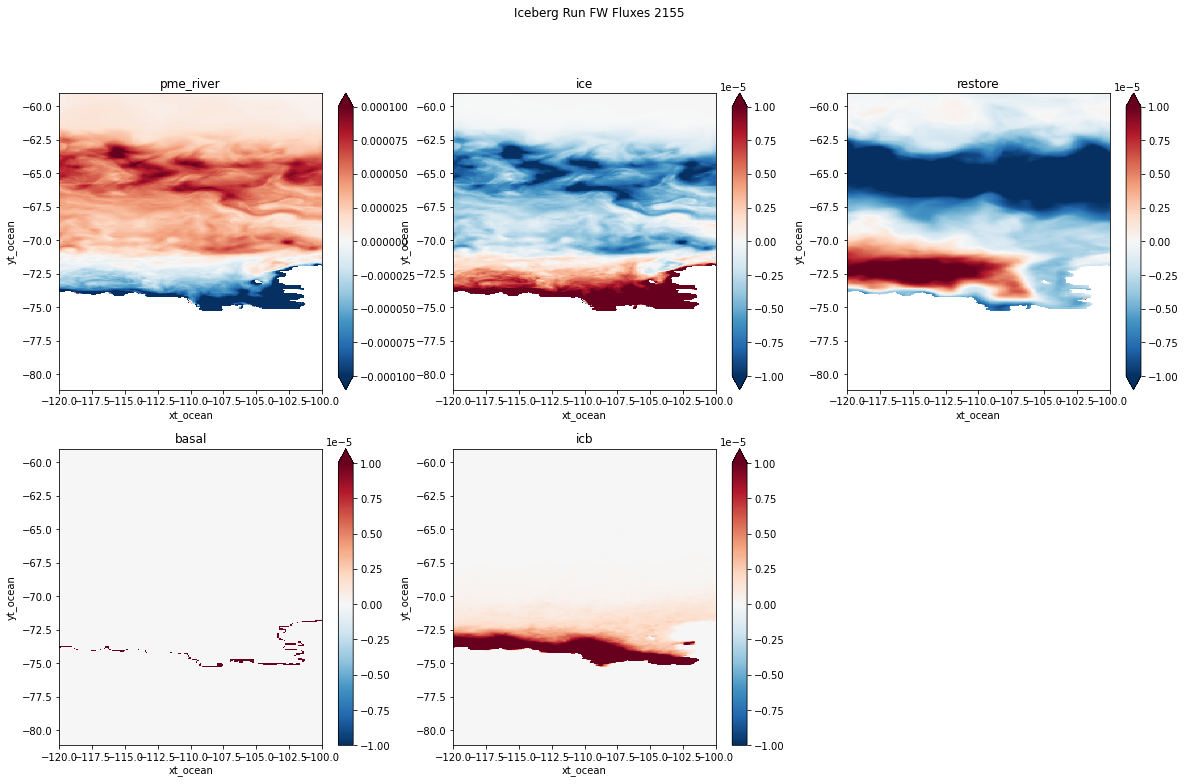

In [28]:
# expt = control
# session = master_session
session = basal_melt_session
expt = iceberg
pme_river_salt_trans,ice,restore,basalh,icb,days_per_month = get_salt_budget_terms(expt, session, start_time, end_time, lat_north)


fig,axes = plt.subplots(nrows = 2, ncols = 3, figsize = (20,12))
(pme_river_salt_trans).sel(xt_ocean = slice(-120,-100)).mean('time').plot(ax = axes[0,0], vmin = -1e-4, vmax = 1e-4,cmap = 'RdBu_r')
axes[0,0].set_title('pme_river')
(-ice).sel(xt_ocean = slice(-120,-100)).mean('time').plot(ax = axes[0,1], vmin = -1e-5, vmax = 1e-5,cmap = 'RdBu_r')
axes[0,1].set_title('ice')
(-restore).sel(xt_ocean = slice(-120,-100)).mean('time').plot(ax = axes[0,2], vmin = -1e-5, vmax = 1e-5,cmap = 'RdBu_r')
axes[0,2].set_title('restore')
(-basalh).sel(xt_ocean = slice(-120,-100)).sum('st_ocean').mean('time').plot(ax = axes[1,0], vmin = -1e-5, vmax = 1e-5,cmap = 'RdBu_r')
axes[1,0].set_title('basal')
(-icb).sel(xt_ocean = slice(-120,-100)).sum('st_ocean').mean('time').plot(ax = axes[1,1], vmin = -1e-5, vmax = 1e-5,cmap = 'RdBu_r')
axes[1,1].set_title('icb')
fig.suptitle('Iceberg Run FW Fluxes 2155')
axes[1,2].axis('off')


ValueError: 'st_ocean' not found in array dimensions ('time', 'yt_ocean', 'xt_ocean')

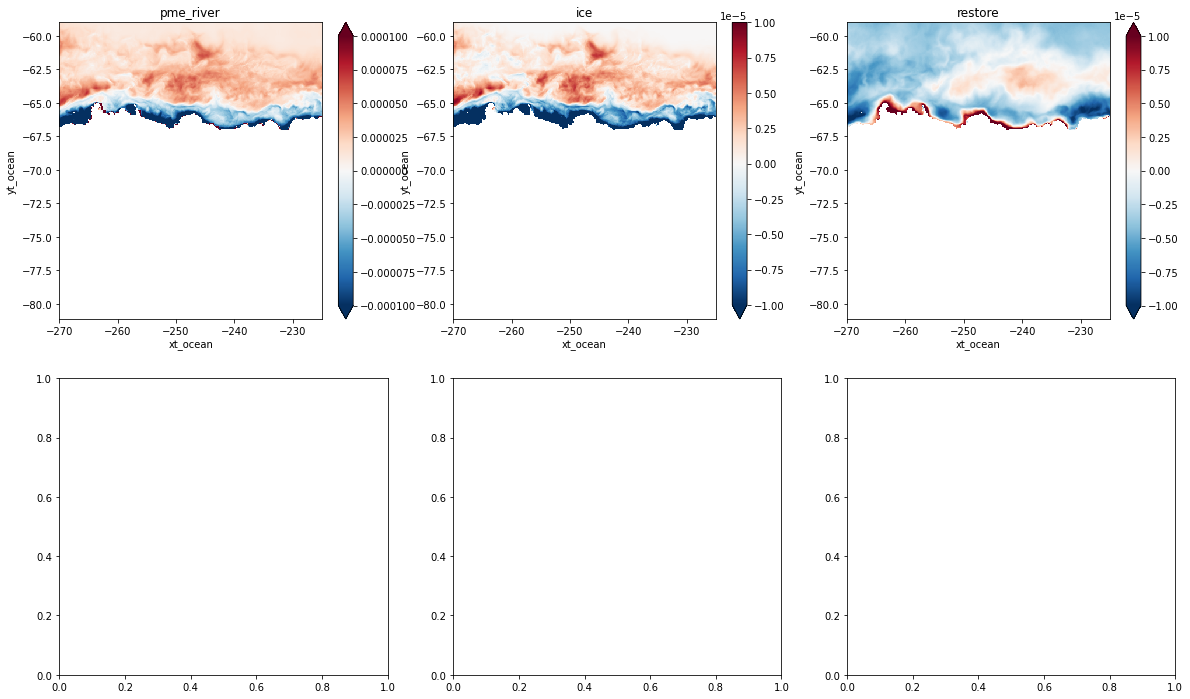

In [25]:
expt = control
session = master_session
# session = basal_melt_session
# expt = iceberg
pme_river_salt_trans,ice,restore,basalh,icb,days_per_month = get_salt_budget_terms(expt, session, start_time, end_time, lat_north)

fig,axes = plt.subplots(nrows = 2, ncols = 3, figsize = (20,12))
(pme_river_salt_trans).sel(xt_ocean = slice(-270,-225)).mean('time').plot(ax = axes[0,0], vmin = -1e-4, vmax = 1e-4,cmap = 'RdBu_r')
axes[0,0].set_title('pme_river')
(ice).sel(xt_ocean = slice(-270,-225)).mean('time').plot(ax = axes[0,1], vmin = -1e-5, vmax = 1e-5,cmap = 'RdBu_r')
axes[0,1].set_title('ice')
(restore).sel(xt_ocean = slice(-270,-225)).mean('time').plot(ax = axes[0,2], vmin = -1e-5, vmax = 1e-5,cmap = 'RdBu_r')
axes[0,2].set_title('restore')
(basalh).sel(xt_ocean = slice(-270,-225)).sum('st_ocean').mean('time').plot(ax = axes[1,0], vmin = -1e-5, vmax = 1e-5,cmap = 'RdBu_r')
axes[1,0].set_title('basal')
(icb).sel(xt_ocean = slice(-270,-225)).sum('st_ocean').mean('time').plot(ax = axes[1,1], vmin = -1e-5, vmax = 1e-5,cmap = 'RdBu_r')
axes[1,1].set_title('icb')
fig.suptitle('Control Run FW Fluxes 2155')
axes[1,2].axis('off')
